# One Pixel Attack Tutorial

![](images/pred2.png "All it takes is one pixel")

### Load Data

Load the Cifar10 dataset and all necessary metadata. Keras will need to download the dataset if it is not cached locally already.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
# Obtain the names of the 10 classes in cifar10
class_names = get_class_names()
print(class_names)

### Imports

In [1]:
# Python Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from scipy.optimize import differential_evolution
from scipy.stats import truncnorm
from IPython.display import clear_output

/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Custom Networks
from networks.lecun_net import LecunNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet

from helper import get_class_names, plot_image, plot_images, evaluate_models, visualize_attack, attack_stats

In [3]:
matplotlib.style.use('ggplot')

Decoding file: data/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Load Models

Load various pretrained Neural Network models in the `networks/models` directory. There are more networks available, but must be trained before testing them here.

In [6]:
lecun_net = LecunNet()
pure_cnn = PureCnn()
net_in_net = NetworkInNetwork()
resnet = ResNet()
# densenet = DenseNet()
# wide_resnet = WideResNet()

models = [lecun_net, pure_cnn, net_in_net, resnet]
# models = [lecun_net, pure_cnn, net_in_net, resnet, densenet, wide_resnet]

Successfully loaded lecun_net
Successfully loaded pure_cnn
Successfully loaded net_in_net
Successfully loaded resnet


### Calculate Model Accuracies

In [7]:
network_stats, correct_imgs = evaluate_models(models, x_test, y_test)

correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

Evaluating lecun_net
Evaluating pure_cnn
Evaluating net_in_net
Evaluating resnet


In [8]:
network_stats

name  accuracy  param_count
0   lecun_net    0.7488        62006
1    pure_cnn    0.8877      1369738
2  net_in_net    0.9074       972658
3      resnet    0.9231       470218

### Image Perturbation

In [9]:
def perturb_image(x, img):
    img = np.copy(img)
    pixels = np.split(x.astype(int), len(x) // 5)
    for pixel in pixels:
        x_pos, y_pos, *rgb = pixel
        img[x_pos, y_pos] = rgb
    return img

### Prediction Function

In [10]:
def predict_class(x, img, target_class, model, minimize=True):
    img_perturbed = perturb_image(x, img)
    prediction = model.predict_one(img_perturbed)[target_class]
    return prediction if minimize else 1 - prediction

### The Attack

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to minimize the probability of the correct classification category and maximize the sum of the probabilities of all other categories.

In [11]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    attack_image = perturb_image(x, x_test[img])
    confidence = model.predict_one(attack_image)
    predicted_class = np.argmax(confidence)
    if (verbose):
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    else:
        return None

In [26]:
def attack(img, model, target=None, pixel_count=1, 
           maxiter=30, popsize=20, verbose=False):
    
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img][0]
    
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Format the predict/callback functions for the differential evolution algorithm
    predict_fn = lambda x: predict_class(
        x, x_test[img], target_class, model, target is None)
    callback_fn = lambda x, convergence: attack_success(
        x, img, target_class, model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popsize,
        atol=-1, callback=callback_fn)

    attack_image = perturb_image(attack_result.x, x_test[img])
    prior_probs = model.predict_one(x_test[img])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img][0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_image]

#### Untargeted Attack

Confidence: 0.99752504
Confidence: 0.979293
Confidence: 0.979293
Confidence: 0.83020115
Confidence: 0.83020115
Confidence: 0.83020115
Confidence: 0.6794645
Confidence: 0.6794645
Confidence: 0.630903
Confidence: 0.630903
Confidence: 0.630903
Confidence: 0.630903
Confidence: 0.6156273
Confidence: 0.6156273
Confidence: 0.28654668


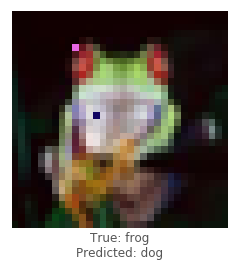

In [31]:
image = 102
_ = attack(image, resnet, pixel_count=2, verbose=True)

#### Targeted Attack

Attacking with target bird
Confidence: 0.026214093
Confidence: 0.026214093
Confidence: 0.026214093
Confidence: 0.026214093
Confidence: 0.026214093
Confidence: 0.026214093
Confidence: 0.039498515
Confidence: 0.039498515
Confidence: 0.039498515
Confidence: 0.039498515
Confidence: 0.039498515
Confidence: 0.039498515
Confidence: 0.088005096
Confidence: 0.088005096
Confidence: 0.088005096
Confidence: 0.097916804
Confidence: 0.097916804
Confidence: 0.097916804
Confidence: 0.097916804
Confidence: 0.097916804
Confidence: 0.097916804
Confidence: 0.097916804
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306
Confidence: 0.44895306


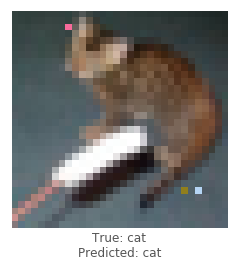

In [35]:
image = 106
target_class = 2 # Integer in range 0-9
print('Attacking with target', class_names[target_class])
_ = attack(image, resnet, target_class, pixel_count=3, maxiter=40, verbose=True)

### Collect Results

In [38]:
def attack_all(models, samples=100, pixels=(1,2,3), targeted=False, verbose=False):
    results = []
    for model in models:
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples)
        for pixel_count in pixels:
            for i,img in enumerate(img_samples):
                print(model.name, '- image', img, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if (targeted):
                        print('Attacking with target', class_names[target])
                        if (target == y_test[img][0]):
                            continue
                    result = attack(img, model, target, pixel_count, 
                                    popsize=(30 // pixel_count), verbose=verbose)
                    results.append(result)
    return results

Attacking image 780 - 1 / 100


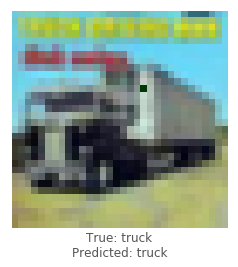

Attacking image 2645 - 2 / 100


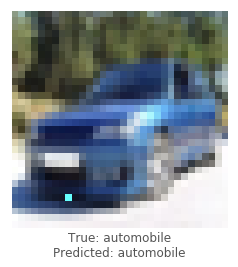

Attacking image 2122 - 3 / 100


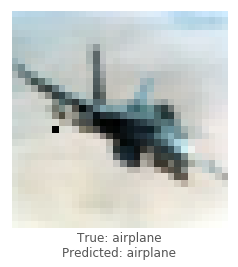

Attacking image 2080 - 4 / 100


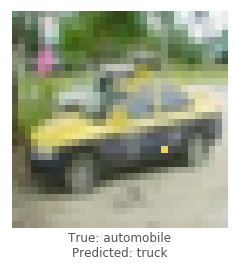

Attacking image 1516 - 5 / 100


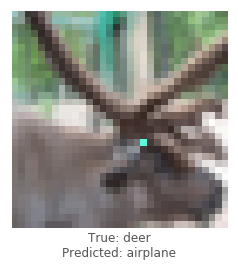

Attacking image 6473 - 6 / 100


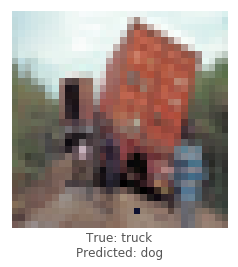

Attacking image 9710 - 7 / 100


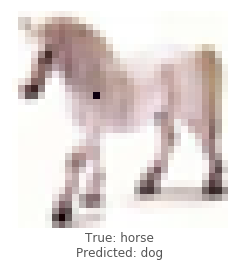

Attacking image 4994 - 8 / 100


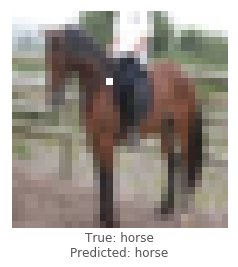

Attacking image 8129 - 9 / 100


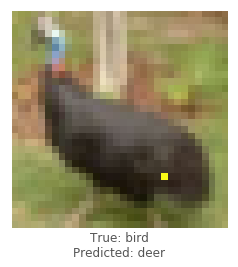

Attacking image 7407 - 10 / 100


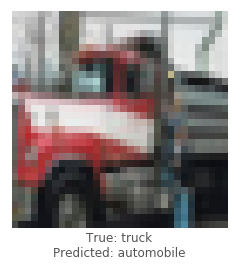

Attacking image 7238 - 11 / 100


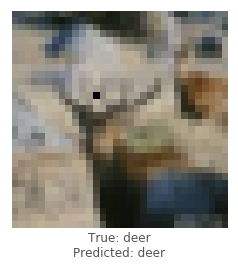

Attacking image 869 - 12 / 100


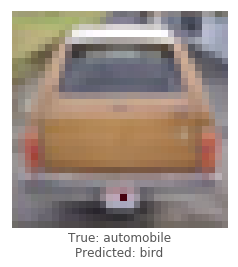

Attacking image 5678 - 13 / 100


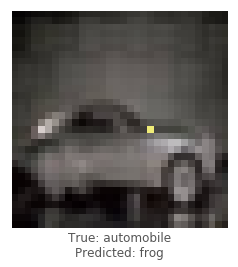

Attacking image 4380 - 14 / 100


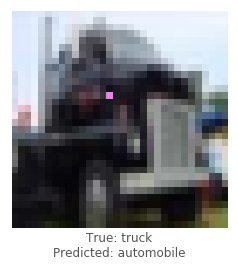

Attacking image 5807 - 15 / 100


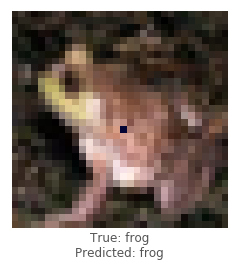

Attacking image 9851 - 16 / 100


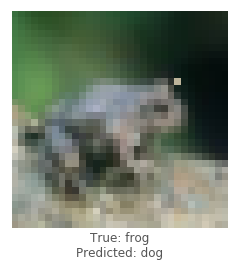

Attacking image 163 - 17 / 100


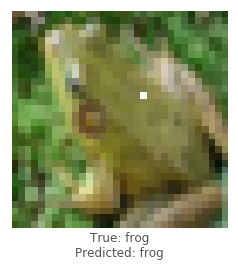

Attacking image 7650 - 18 / 100


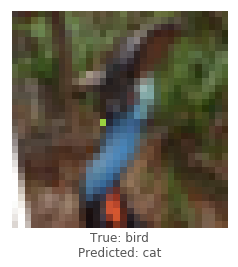

Attacking image 322 - 19 / 100


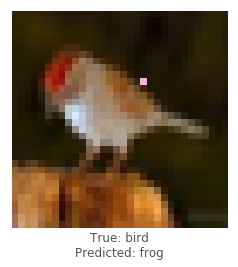

Attacking image 8362 - 20 / 100


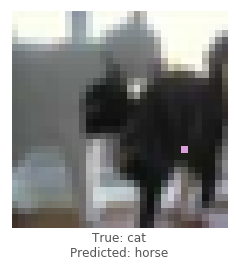

Attacking image 3665 - 21 / 100


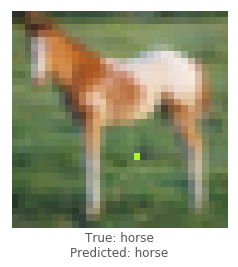

Attacking image 9803 - 22 / 100


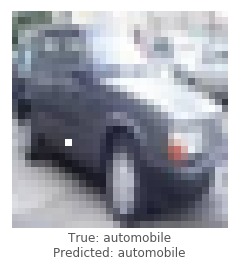

Attacking image 3272 - 23 / 100


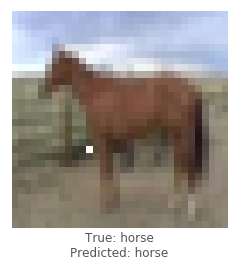

Attacking image 595 - 24 / 100


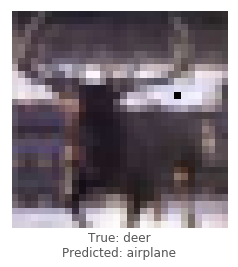

Attacking image 47 - 25 / 100


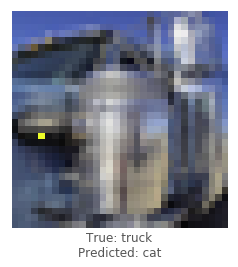

Attacking image 3200 - 26 / 100


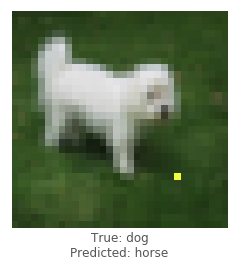

Attacking image 3579 - 27 / 100


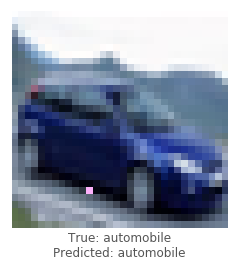

Attacking image 2458 - 28 / 100


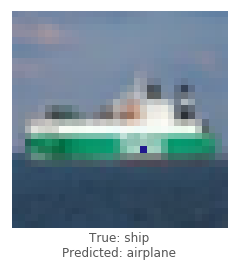

Attacking image 2800 - 29 / 100


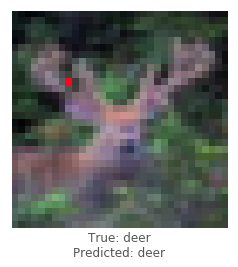

Attacking image 1519 - 30 / 100


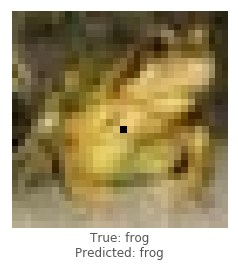

Attacking image 8264 - 31 / 100


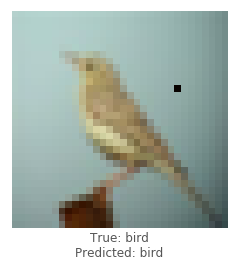

Attacking image 3841 - 32 / 100


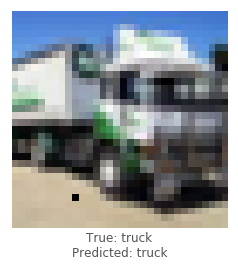

Attacking image 4445 - 33 / 100


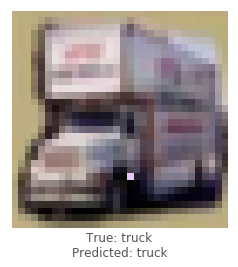

Attacking image 2275 - 34 / 100


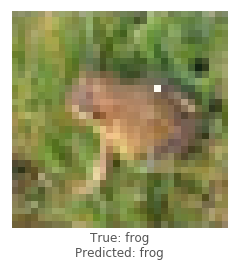

Attacking image 49 - 35 / 100


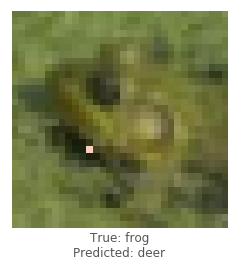

Attacking image 5499 - 36 / 100


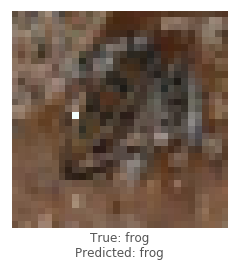

Attacking image 925 - 37 / 100


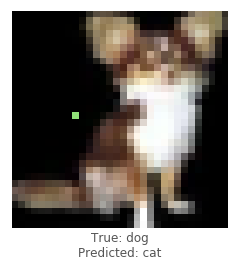

Attacking image 8674 - 38 / 100


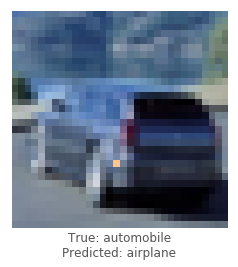

Attacking image 8991 - 39 / 100


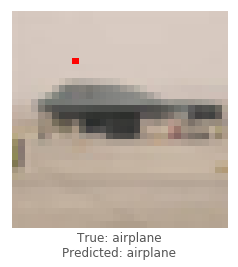

Attacking image 5194 - 40 / 100


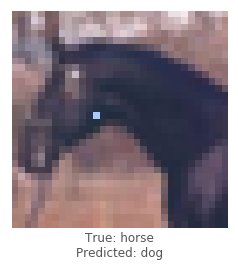

Attacking image 268 - 41 / 100


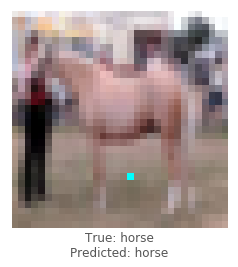

Attacking image 9004 - 42 / 100


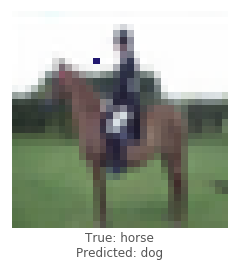

Attacking image 7467 - 43 / 100


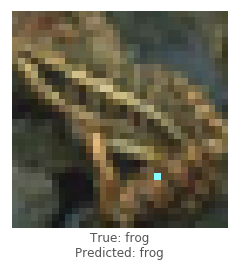

Attacking image 2784 - 44 / 100


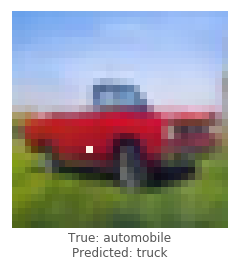

Attacking image 597 - 45 / 100


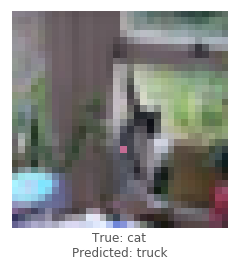

Attacking image 4329 - 46 / 100


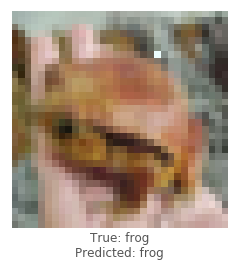

Attacking image 2796 - 47 / 100


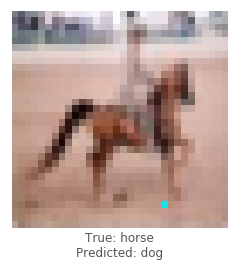

Attacking image 602 - 48 / 100


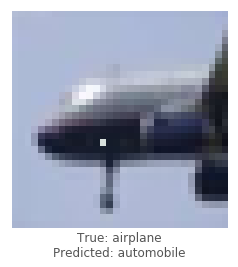

Attacking image 227 - 49 / 100


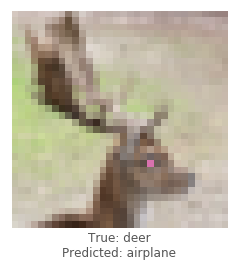

Attacking image 7693 - 50 / 100


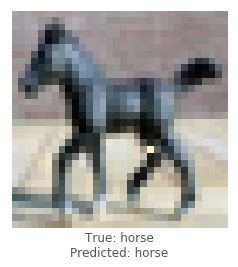

Attacking image 3842 - 51 / 100


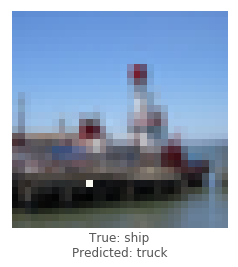

Attacking image 1208 - 52 / 100


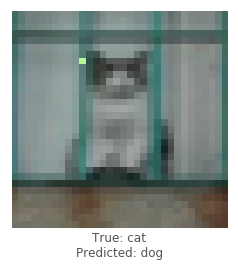

Attacking image 9276 - 53 / 100


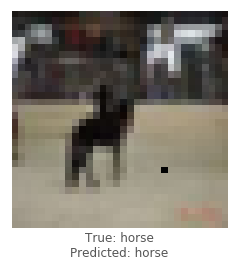

Attacking image 9460 - 54 / 100


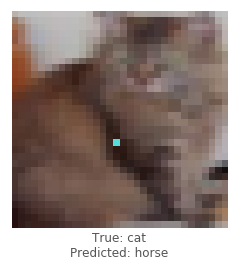

Attacking image 8276 - 55 / 100


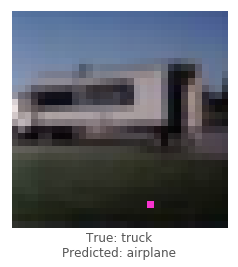

Attacking image 8934 - 56 / 100


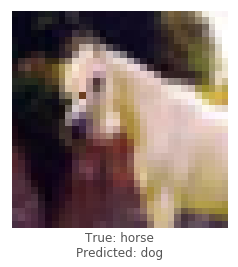

Attacking image 2110 - 57 / 100


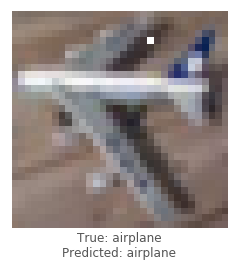

Attacking image 7705 - 58 / 100


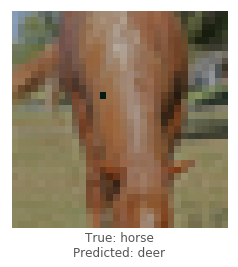

Attacking image 5630 - 59 / 100


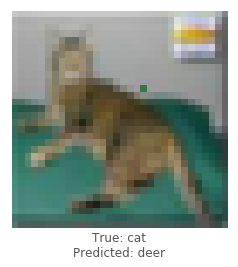

Attacking image 195 - 60 / 100


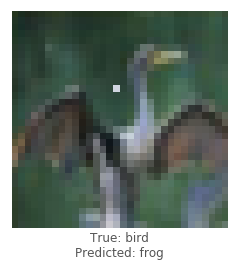

Attacking image 16 - 61 / 100


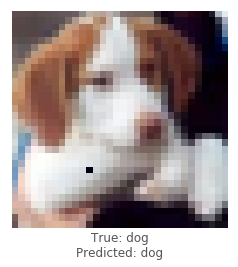

Attacking image 4796 - 62 / 100


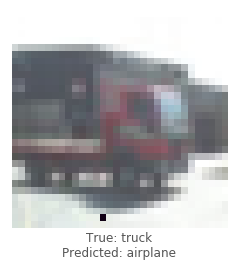

Attacking image 6002 - 63 / 100


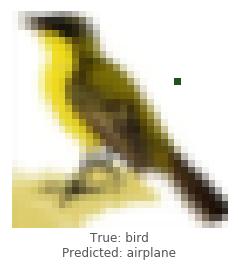

Attacking image 6724 - 64 / 100


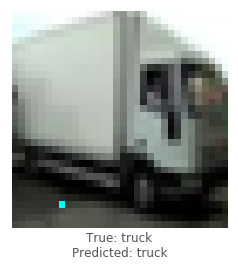

Attacking image 4327 - 65 / 100


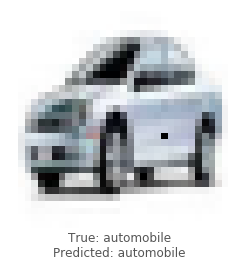

Attacking image 2474 - 66 / 100


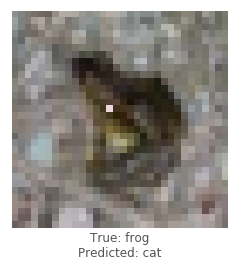

Attacking image 4704 - 67 / 100


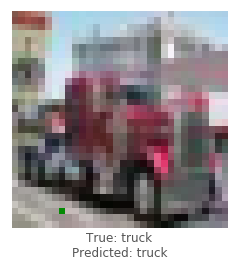

Attacking image 6276 - 68 / 100


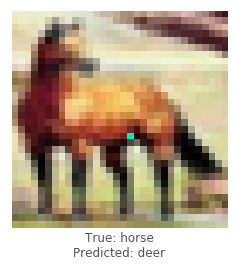

Attacking image 664 - 69 / 100


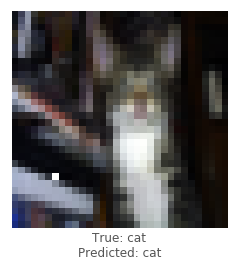

Attacking image 2611 - 70 / 100


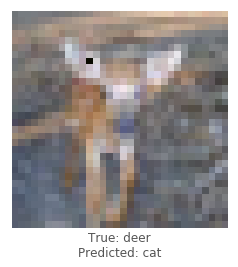

Attacking image 7147 - 71 / 100


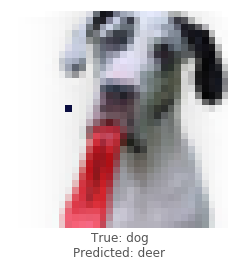

Attacking image 1714 - 72 / 100


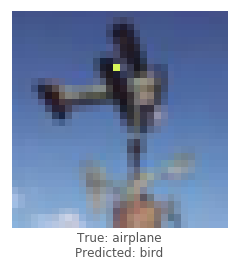

Attacking image 3937 - 73 / 100


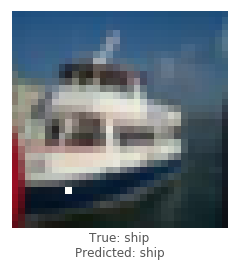

Attacking image 7316 - 74 / 100


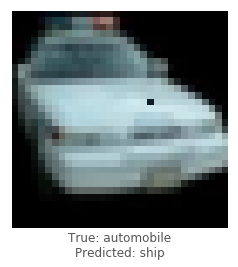

Attacking image 95 - 75 / 100


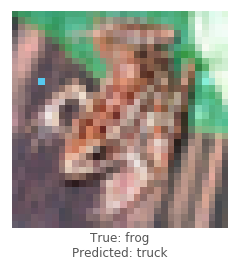

Attacking image 7057 - 76 / 100


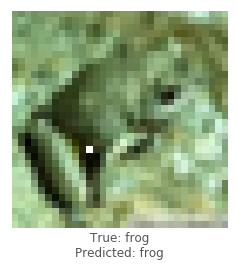

Attacking image 5990 - 77 / 100


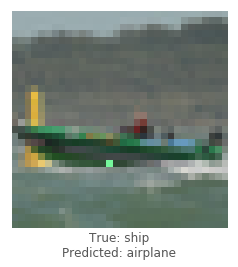

Attacking image 6967 - 78 / 100


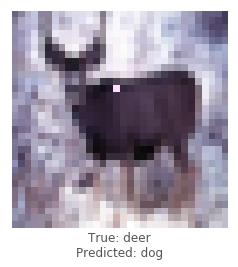

Attacking image 4607 - 79 / 100


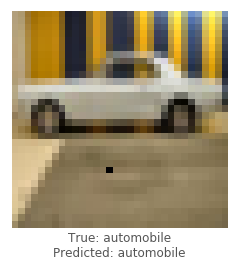

Attacking image 2918 - 80 / 100


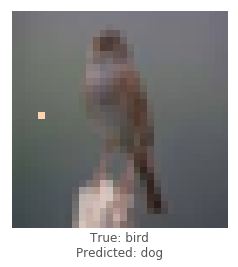

Attacking image 8078 - 81 / 100


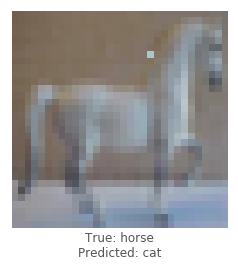

Attacking image 1579 - 82 / 100


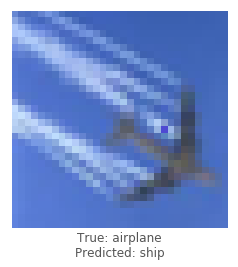

Attacking image 7463 - 83 / 100


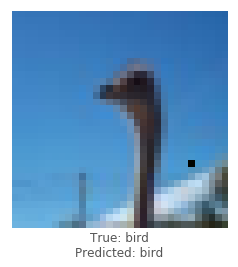

Attacking image 5740 - 84 / 100


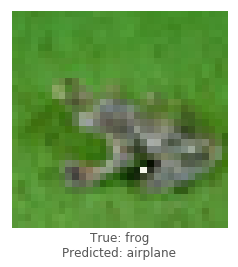

Attacking image 2436 - 85 / 100


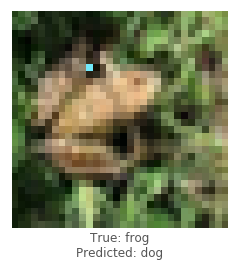

Attacking image 549 - 86 / 100


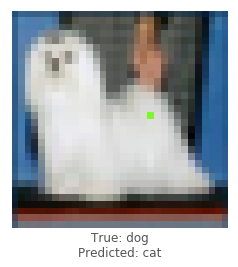

Attacking image 6733 - 87 / 100


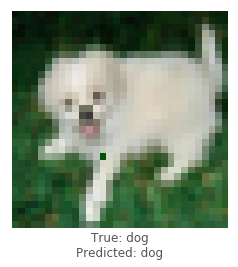

Attacking image 3852 - 88 / 100


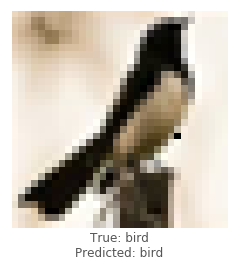

Attacking image 2638 - 89 / 100


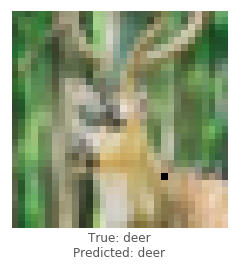

Attacking image 1591 - 90 / 100


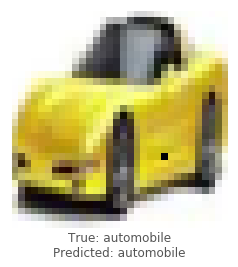

Attacking image 6890 - 91 / 100


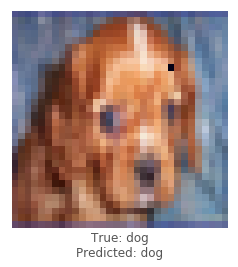

Attacking image 1007 - 92 / 100


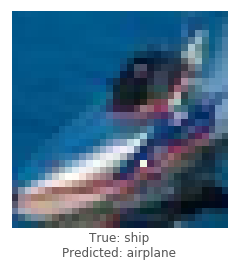

Attacking image 3796 - 93 / 100


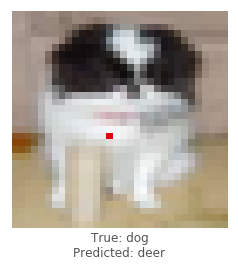

Attacking image 6855 - 94 / 100


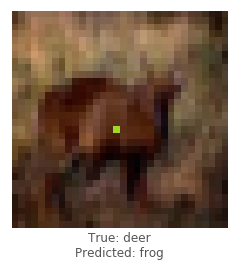

Attacking image 9878 - 95 / 100


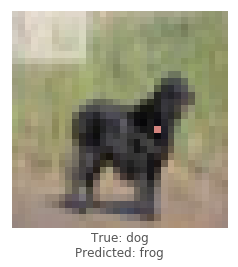

Attacking image 7728 - 96 / 100


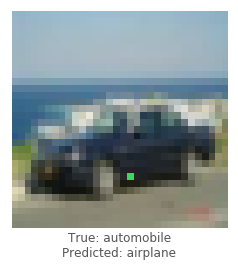

Attacking image 4508 - 97 / 100


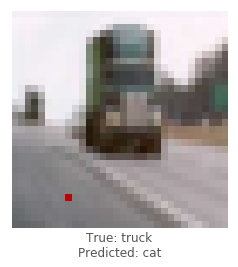

Attacking image 9956 - 98 / 100


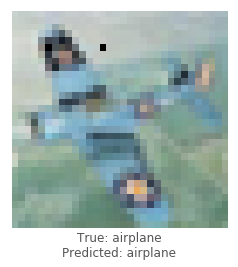

Attacking image 979 - 99 / 100


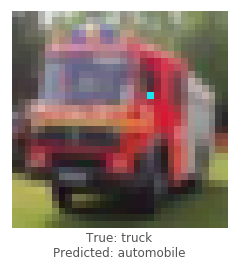

Attacking image 5015 - 100 / 100


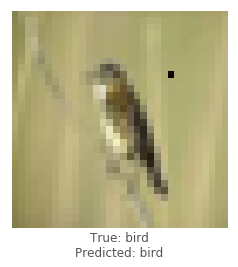

Attacking image 8329 - 1 / 100


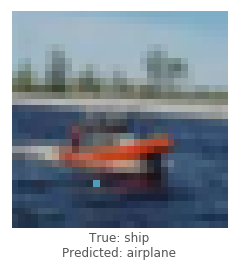

Attacking image 3233 - 2 / 100


/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:533: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


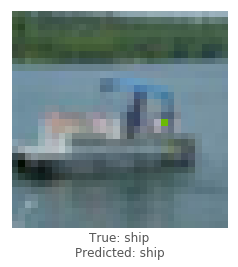

Attacking image 7026 - 3 / 100


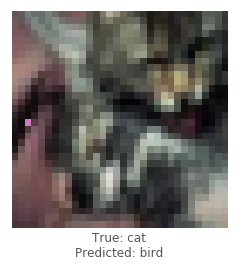

Attacking image 1160 - 4 / 100


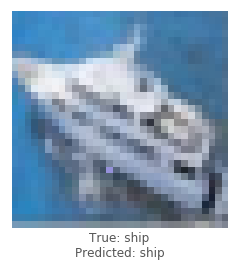

Attacking image 5121 - 5 / 100


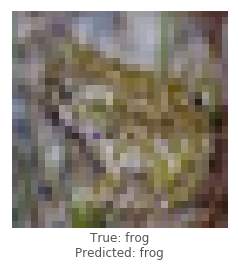

Attacking image 7505 - 6 / 100


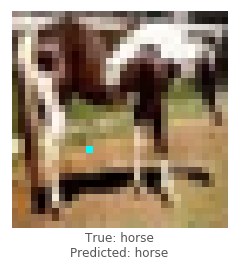

Attacking image 3031 - 7 / 100


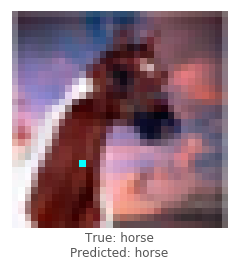

Attacking image 9890 - 8 / 100


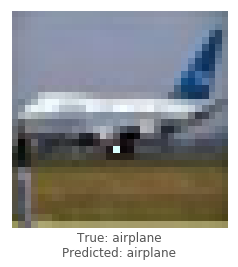

Attacking image 2808 - 9 / 100


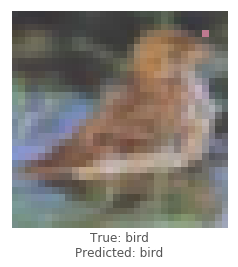

Attacking image 758 - 10 / 100


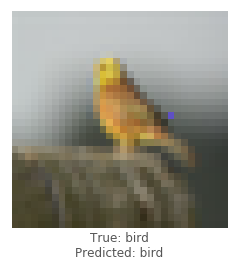

Attacking image 8997 - 11 / 100


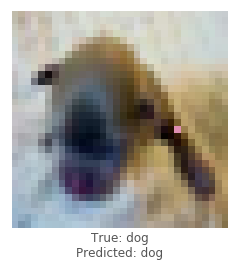

Attacking image 6904 - 12 / 100


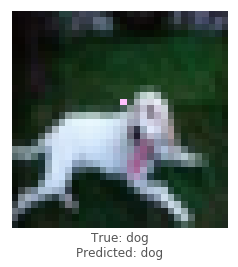

Attacking image 29 - 13 / 100


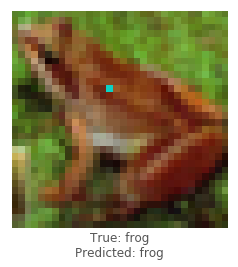

Attacking image 2143 - 14 / 100


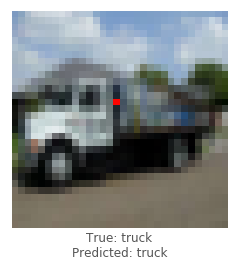

Attacking image 1699 - 15 / 100


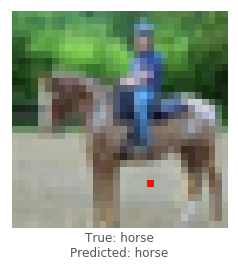

Attacking image 8611 - 16 / 100


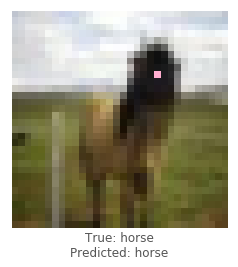

Attacking image 2419 - 17 / 100


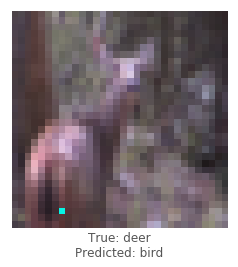

Attacking image 9627 - 18 / 100


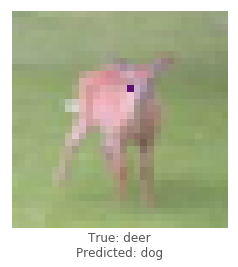

Attacking image 2628 - 19 / 100


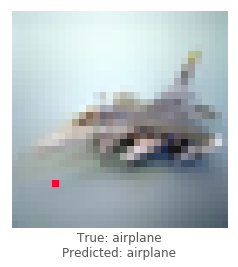

Attacking image 8275 - 20 / 100


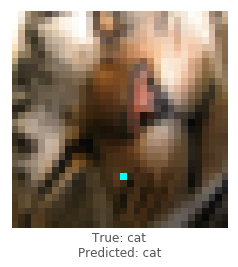

Attacking image 2389 - 21 / 100


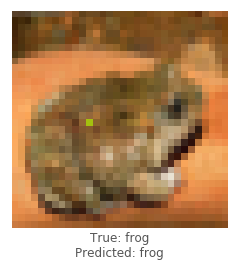

Attacking image 1699 - 22 / 100


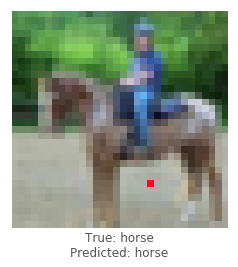

Attacking image 2391 - 23 / 100


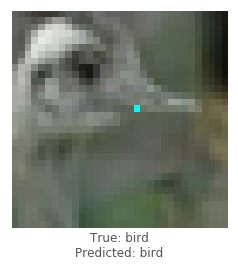

Attacking image 462 - 24 / 100


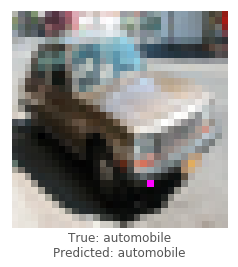

Attacking image 2991 - 25 / 100


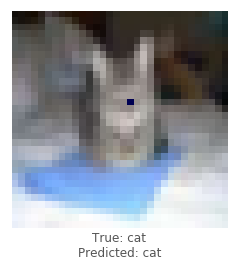

Attacking image 403 - 26 / 100


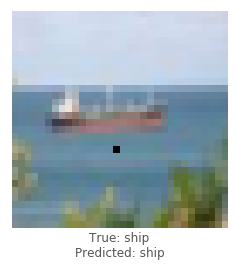

Attacking image 9402 - 27 / 100


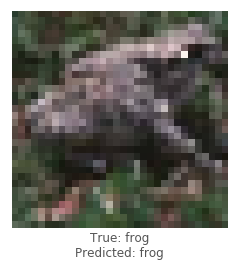

Attacking image 1031 - 28 / 100


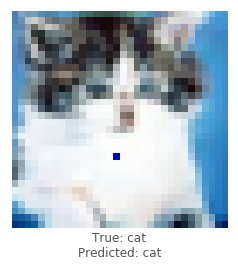

Attacking image 7207 - 29 / 100


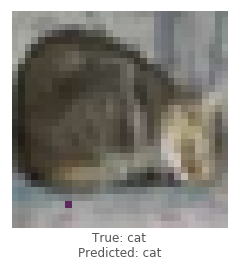

Attacking image 1563 - 30 / 100


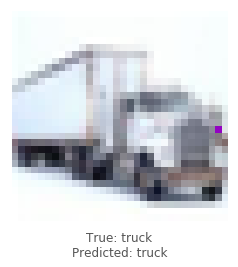

Attacking image 1664 - 31 / 100


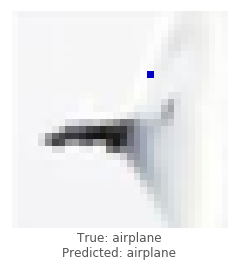

Attacking image 6904 - 32 / 100


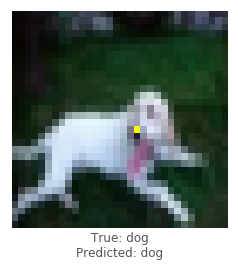

Attacking image 3783 - 33 / 100


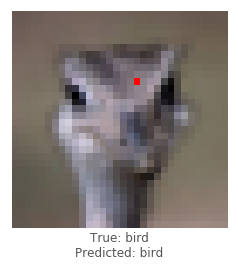

Attacking image 3425 - 34 / 100


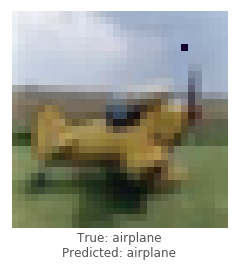

Attacking image 3506 - 35 / 100


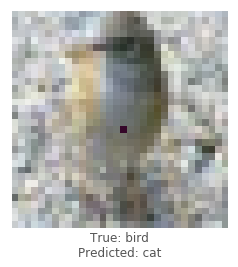

Attacking image 2454 - 36 / 100


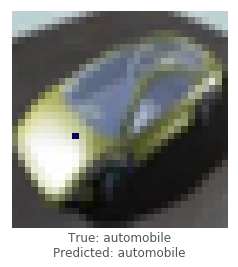

Attacking image 3751 - 37 / 100


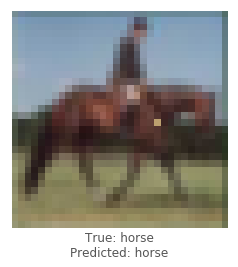

Attacking image 3122 - 38 / 100


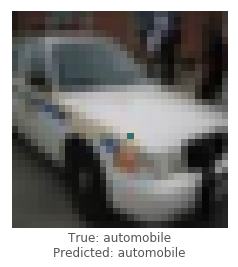

Attacking image 5793 - 39 / 100


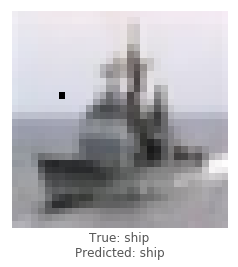

Attacking image 9733 - 40 / 100


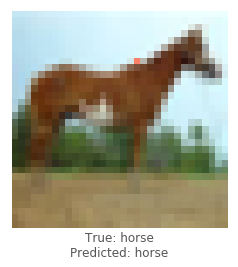

Attacking image 7156 - 41 / 100


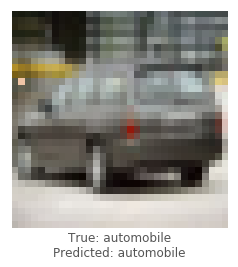

Attacking image 2720 - 42 / 100


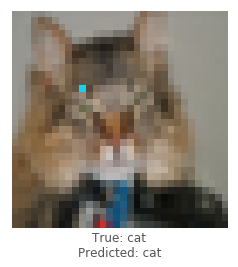

Attacking image 2401 - 43 / 100


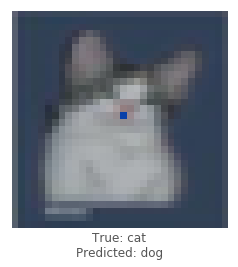

Attacking image 6429 - 44 / 100


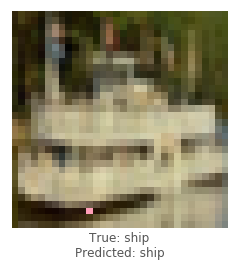

Attacking image 8171 - 45 / 100


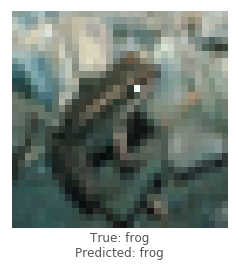

Attacking image 8005 - 46 / 100


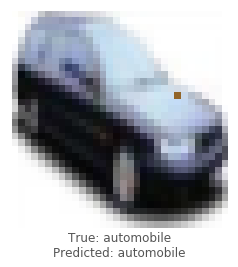

Attacking image 4985 - 47 / 100


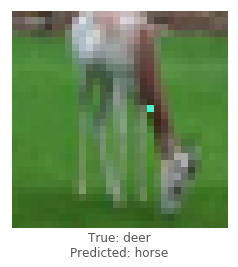

Attacking image 176 - 48 / 100


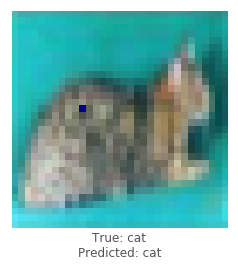

Attacking image 4191 - 49 / 100


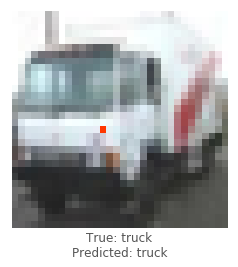

Attacking image 4721 - 50 / 100


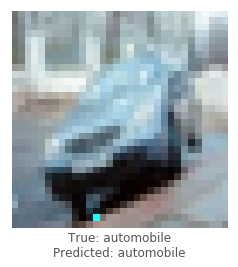

Attacking image 750 - 51 / 100


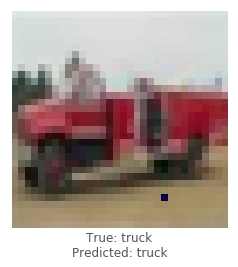

Attacking image 8114 - 52 / 100


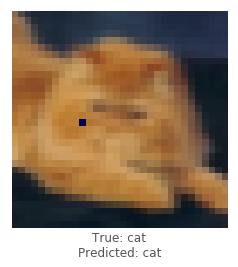

Attacking image 3344 - 53 / 100


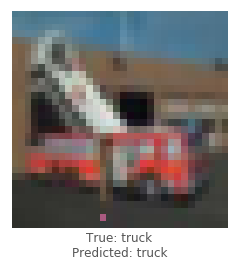

Attacking image 267 - 54 / 100


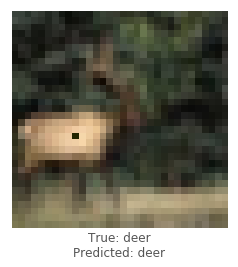

Attacking image 1123 - 55 / 100


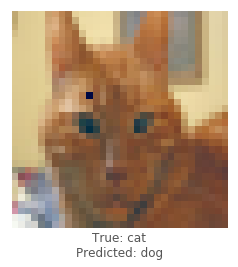

Attacking image 2941 - 56 / 100


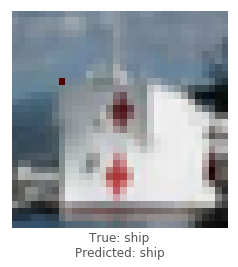

Attacking image 7553 - 57 / 100


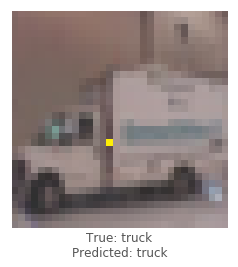

Attacking image 8594 - 58 / 100


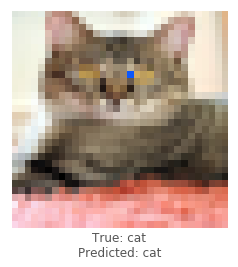

Attacking image 4589 - 59 / 100


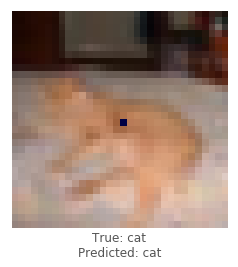

Attacking image 2176 - 60 / 100


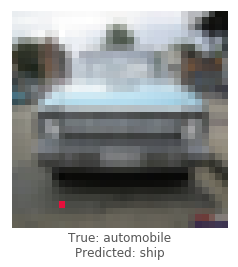

Attacking image 1412 - 61 / 100


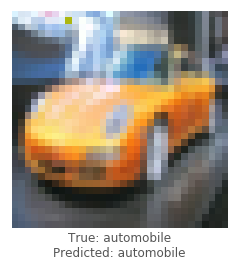

Attacking image 1423 - 62 / 100


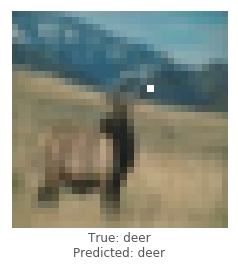

Attacking image 2509 - 63 / 100


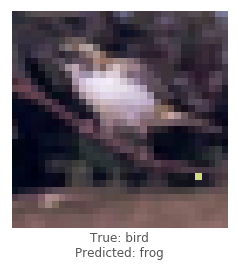

Attacking image 3084 - 64 / 100


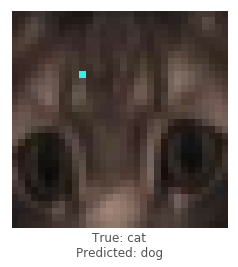

Attacking image 4955 - 65 / 100


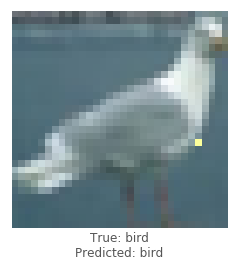

Attacking image 4572 - 66 / 100


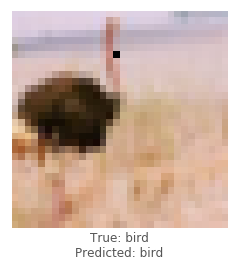

Attacking image 97 - 67 / 100


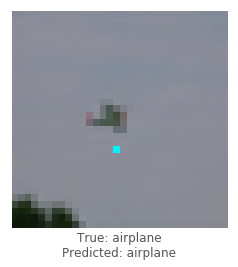

Attacking image 362 - 68 / 100


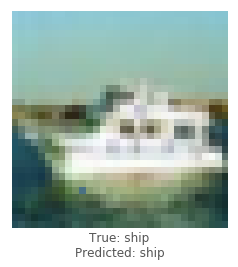

Attacking image 2865 - 69 / 100


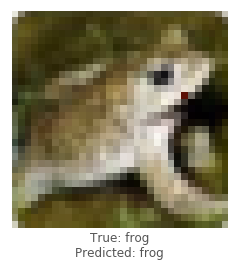

Attacking image 5875 - 70 / 100


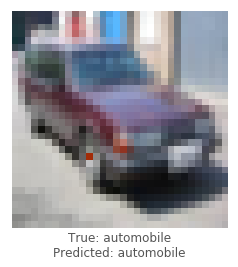

Attacking image 3917 - 71 / 100


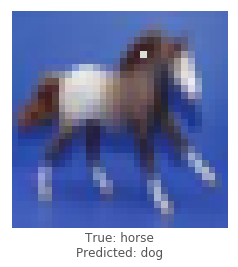

Attacking image 5245 - 72 / 100


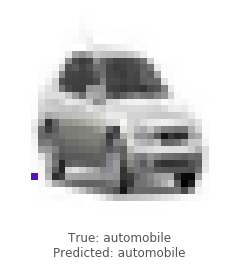

Attacking image 9778 - 73 / 100


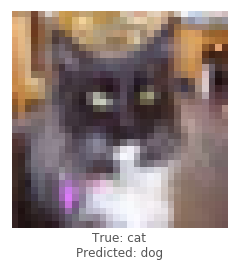

Attacking image 6835 - 74 / 100


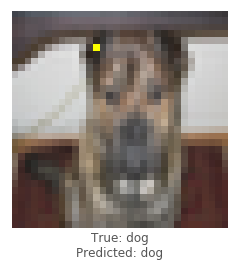

Attacking image 7183 - 75 / 100


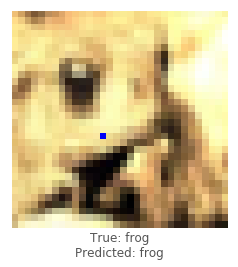

Attacking image 6222 - 76 / 100


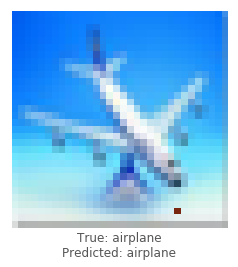

Attacking image 2194 - 77 / 100


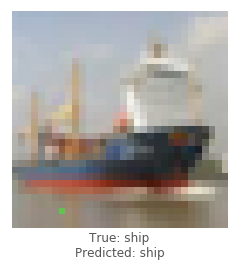

Attacking image 1991 - 78 / 100


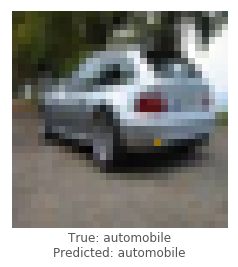

Attacking image 4921 - 79 / 100


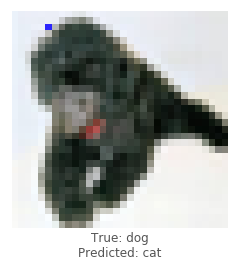

Attacking image 9318 - 80 / 100


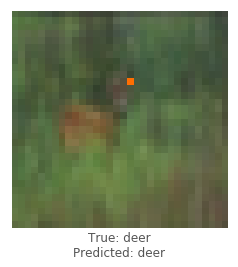

Attacking image 5359 - 81 / 100


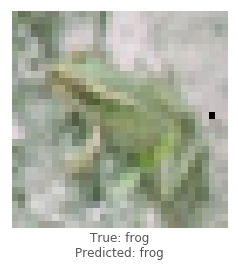

Attacking image 9562 - 82 / 100


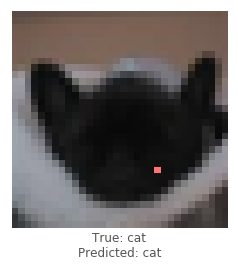

Attacking image 4019 - 83 / 100


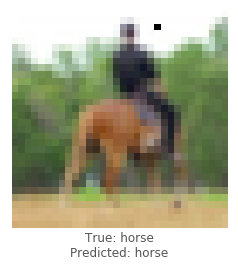

Attacking image 685 - 84 / 100


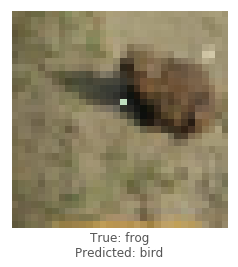

Attacking image 781 - 85 / 100


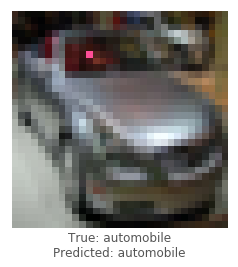

Attacking image 7585 - 86 / 100


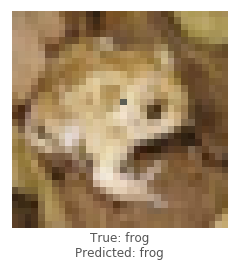

Attacking image 6298 - 87 / 100


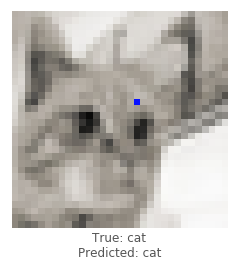

Attacking image 8135 - 88 / 100


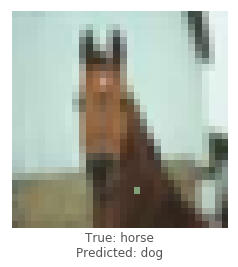

Attacking image 1944 - 89 / 100


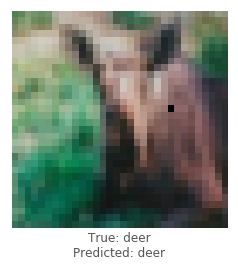

Attacking image 1471 - 90 / 100


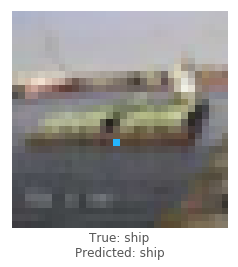

Attacking image 4689 - 91 / 100


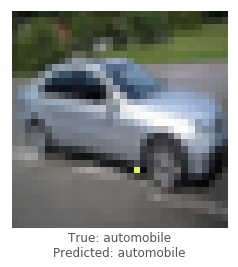

Attacking image 7832 - 92 / 100


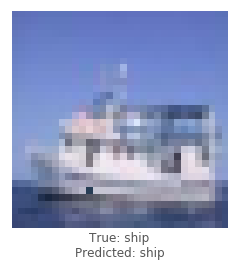

Attacking image 7563 - 93 / 100


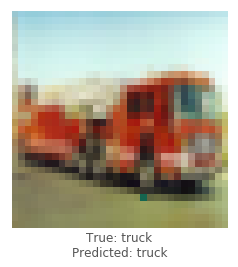

Attacking image 4722 - 94 / 100


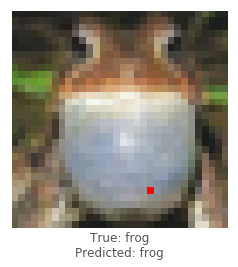

Attacking image 5390 - 95 / 100


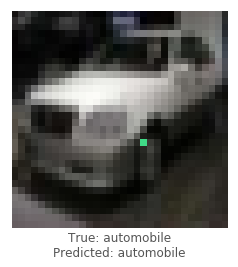

Attacking image 6119 - 96 / 100


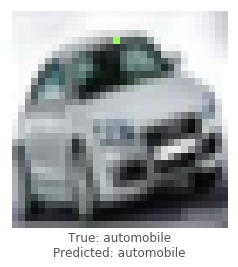

Attacking image 4042 - 97 / 100


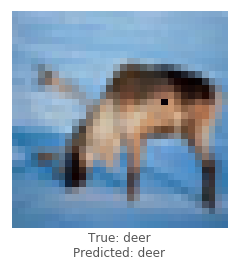

Attacking image 1264 - 98 / 100


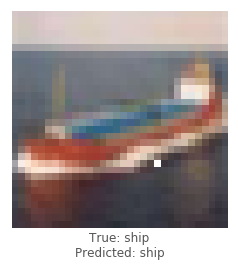

Attacking image 6849 - 99 / 100


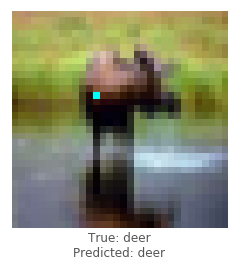

Attacking image 8755 - 100 / 100


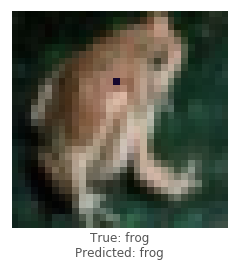

Attacking image 8019 - 1 / 100


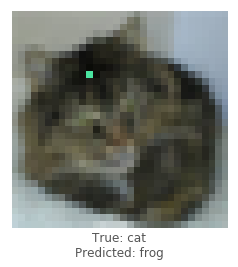

Attacking image 9320 - 2 / 100


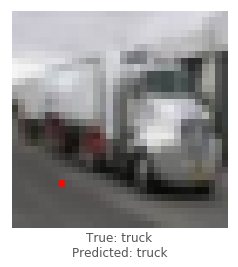

Attacking image 6247 - 3 / 100


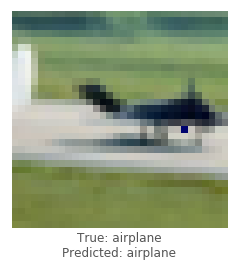

Attacking image 5960 - 4 / 100


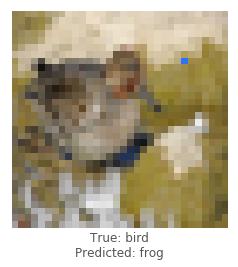

Attacking image 453 - 5 / 100


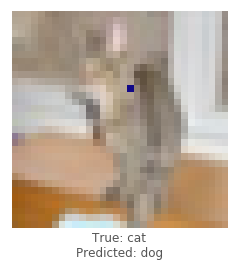

Attacking image 1863 - 6 / 100


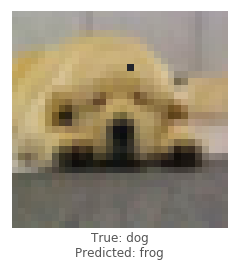

Attacking image 3051 - 7 / 100


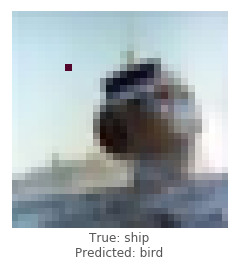

Attacking image 7460 - 8 / 100


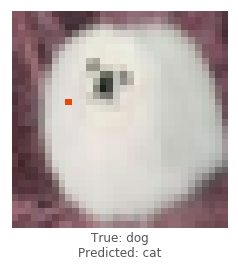

Attacking image 5009 - 9 / 100


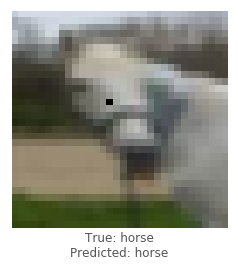

Attacking image 4804 - 10 / 100


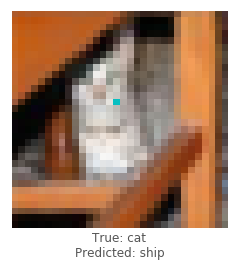

Attacking image 5790 - 11 / 100


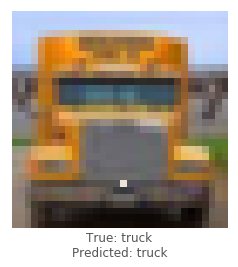

Attacking image 7337 - 12 / 100


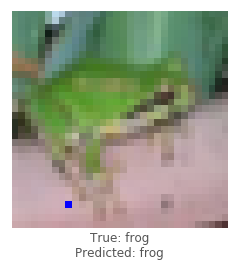

Attacking image 517 - 13 / 100


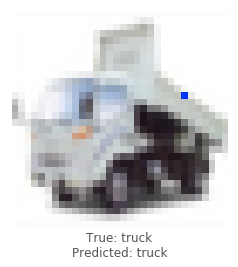

Attacking image 3417 - 14 / 100


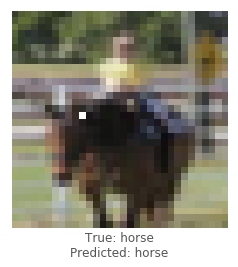

Attacking image 1451 - 15 / 100


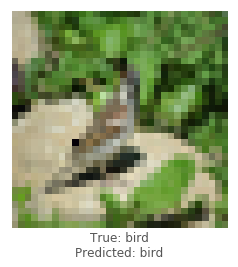

Attacking image 3973 - 16 / 100


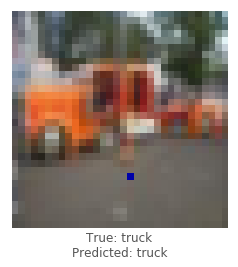

Attacking image 449 - 17 / 100


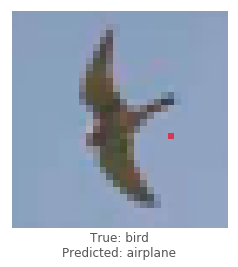

Attacking image 3877 - 18 / 100


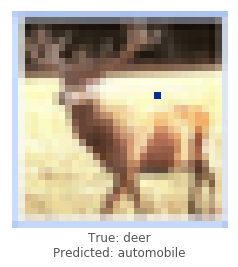

Attacking image 2704 - 19 / 100


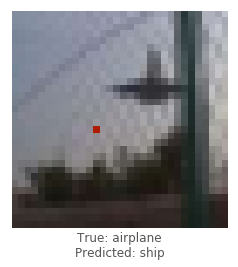

Attacking image 1286 - 20 / 100


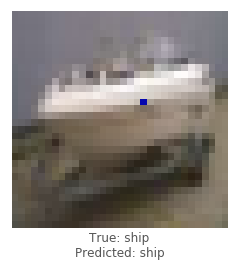

Attacking image 7098 - 21 / 100


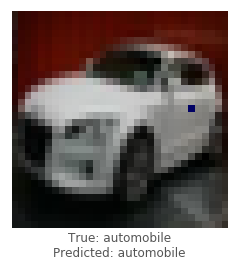

Attacking image 414 - 22 / 100


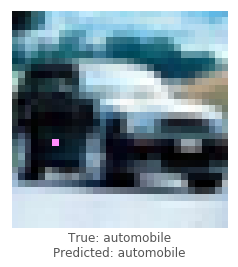

Attacking image 1652 - 23 / 100


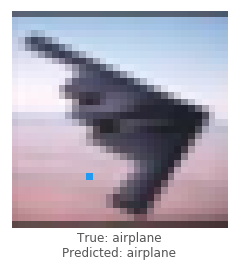

Attacking image 4985 - 24 / 100


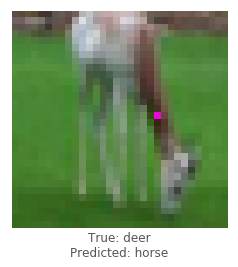

Attacking image 8463 - 25 / 100


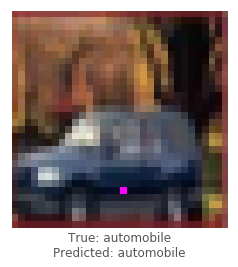

Attacking image 2163 - 26 / 100


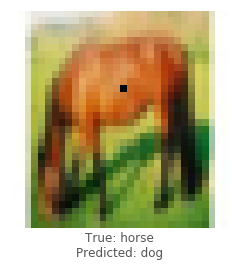

Attacking image 2153 - 27 / 100


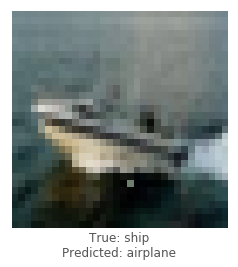

Attacking image 1338 - 28 / 100


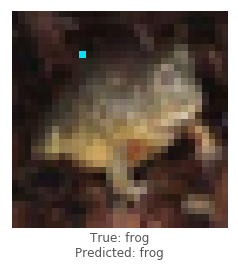

Attacking image 460 - 29 / 100


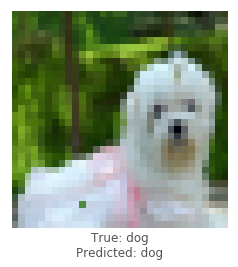

Attacking image 4061 - 30 / 100


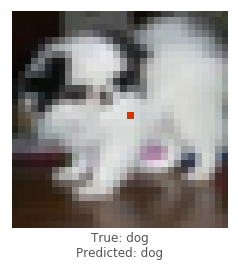

Attacking image 5803 - 31 / 100


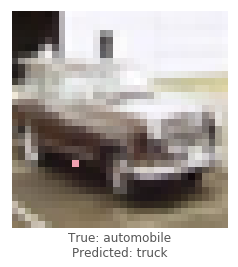

Attacking image 4584 - 32 / 100


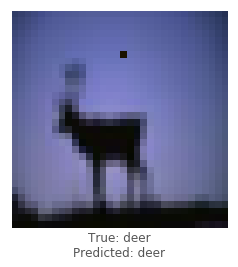

Attacking image 1946 - 33 / 100


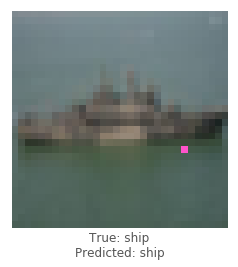

Attacking image 5700 - 34 / 100


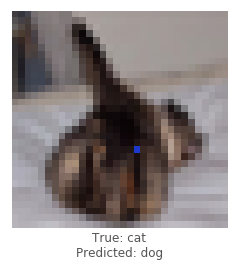

Attacking image 3332 - 35 / 100


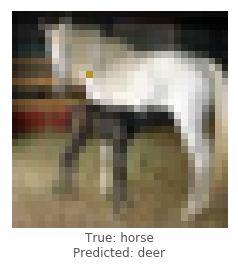

Attacking image 5509 - 36 / 100


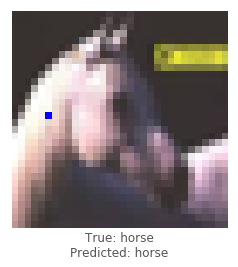

Attacking image 1108 - 37 / 100


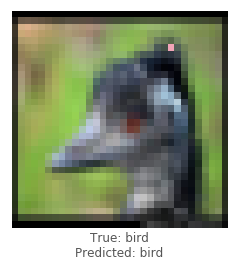

Attacking image 7838 - 38 / 100


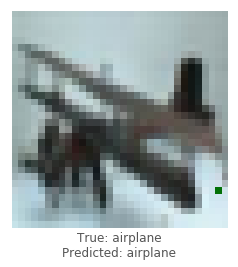

Attacking image 1451 - 39 / 100


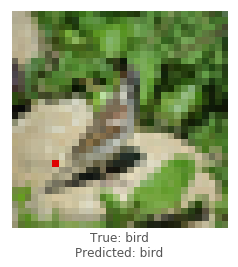

Attacking image 1460 - 40 / 100


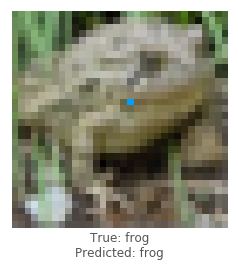

Attacking image 6446 - 41 / 100


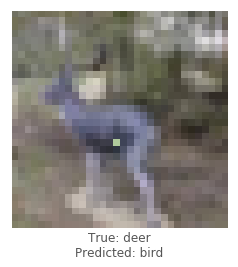

Attacking image 7823 - 42 / 100


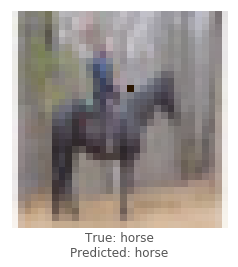

Attacking image 5639 - 43 / 100


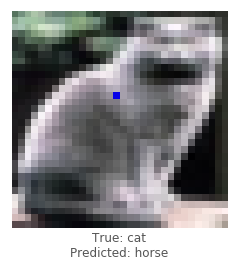

Attacking image 4858 - 44 / 100


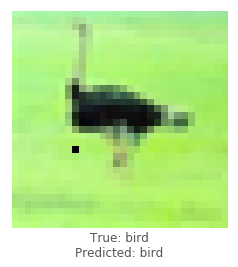

Attacking image 7610 - 45 / 100


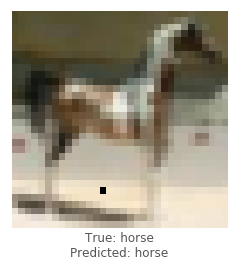

Attacking image 613 - 46 / 100


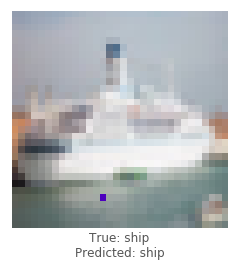

Attacking image 8459 - 47 / 100


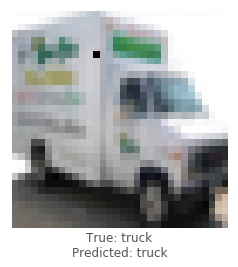

Attacking image 2003 - 48 / 100


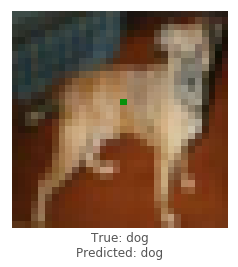

Attacking image 7198 - 49 / 100


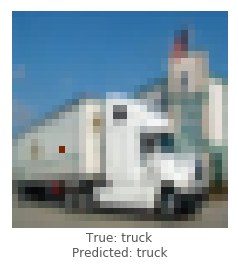

Attacking image 3173 - 50 / 100


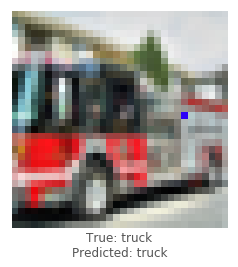

Attacking image 9339 - 51 / 100


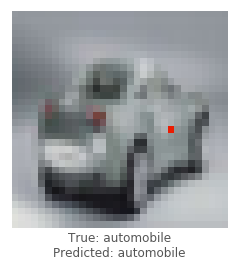

Attacking image 7650 - 52 / 100


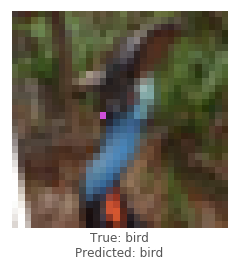

Attacking image 3005 - 53 / 100


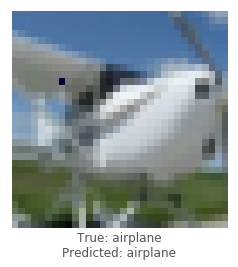

Attacking image 2888 - 54 / 100


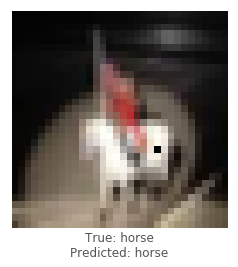

Attacking image 7533 - 55 / 100


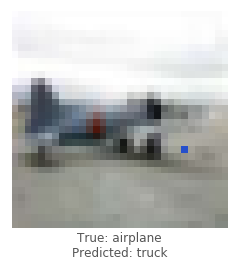

Attacking image 7767 - 56 / 100


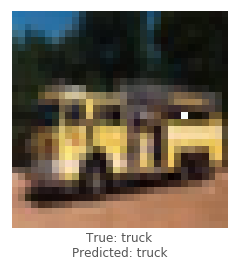

Attacking image 362 - 57 / 100


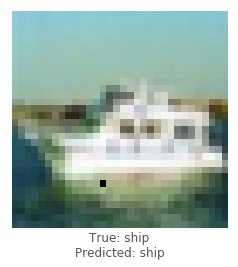

Attacking image 1979 - 58 / 100


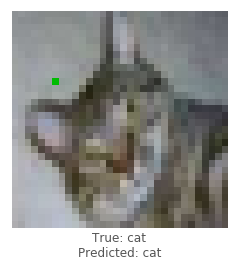

Attacking image 1500 - 59 / 100


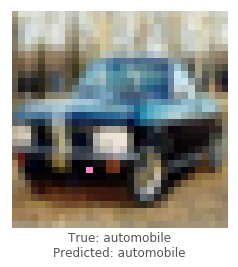

Attacking image 7111 - 60 / 100


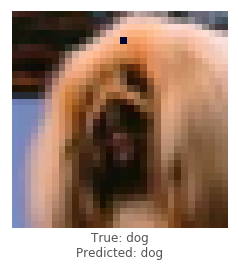

Attacking image 1046 - 61 / 100


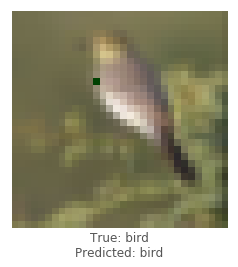

Attacking image 7365 - 62 / 100


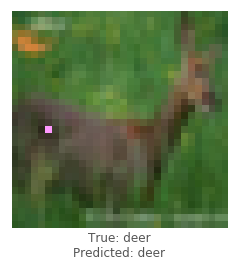

Attacking image 1103 - 63 / 100


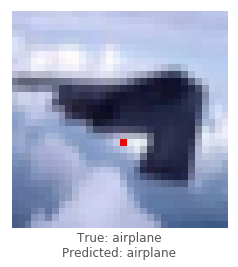

Attacking image 6107 - 64 / 100


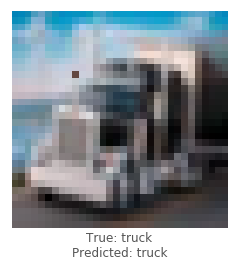

Attacking image 7825 - 65 / 100


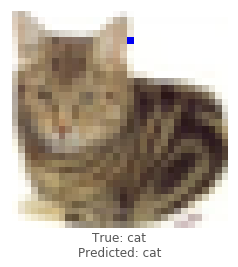

Attacking image 8311 - 66 / 100


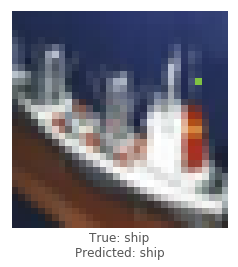

Attacking image 7499 - 67 / 100


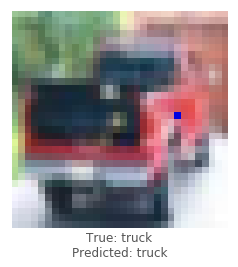

Attacking image 7216 - 68 / 100


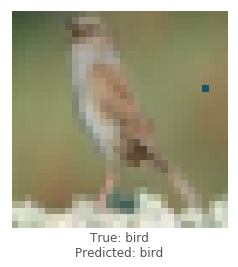

Attacking image 2657 - 69 / 100


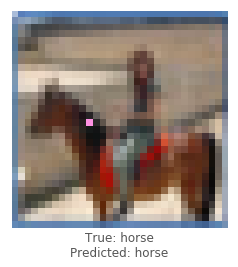

Attacking image 5717 - 70 / 100


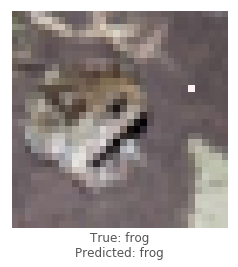

Attacking image 3009 - 71 / 100


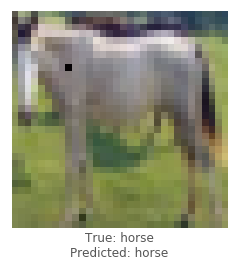

Attacking image 6277 - 72 / 100


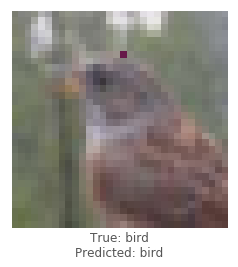

Attacking image 9061 - 73 / 100


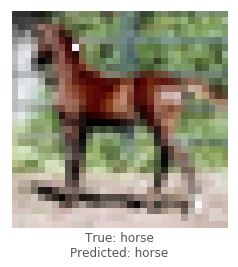

Attacking image 1464 - 74 / 100


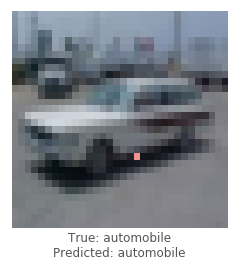

Attacking image 7487 - 75 / 100


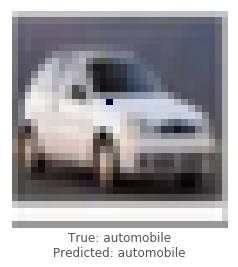

Attacking image 2600 - 76 / 100


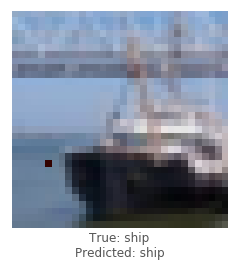

Attacking image 2731 - 77 / 100


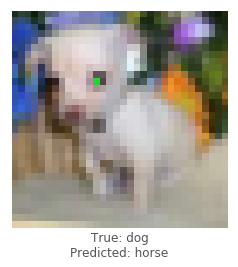

Attacking image 6882 - 78 / 100


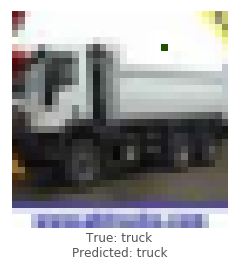

Attacking image 4207 - 79 / 100


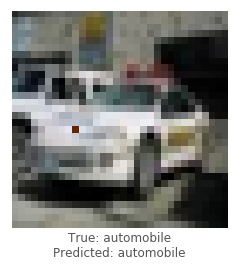

Attacking image 5740 - 80 / 100


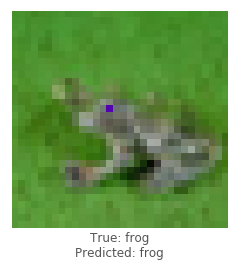

Attacking image 896 - 81 / 100


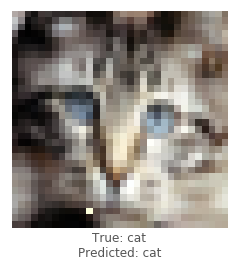

Attacking image 4028 - 82 / 100


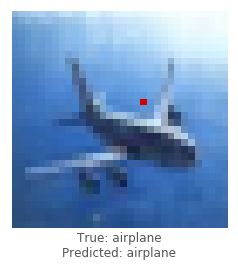

Attacking image 8135 - 83 / 100


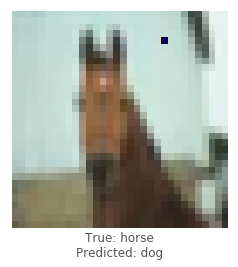

Attacking image 9404 - 84 / 100


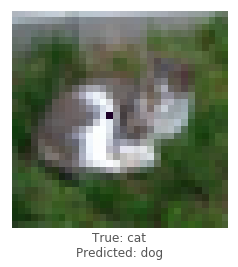

Attacking image 8998 - 85 / 100


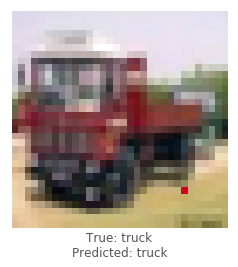

Attacking image 6924 - 86 / 100


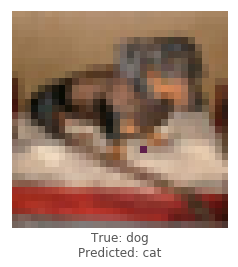

Attacking image 4235 - 87 / 100


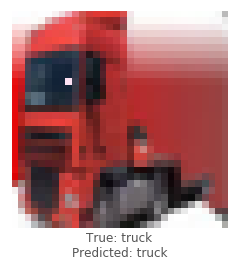

Attacking image 9935 - 88 / 100


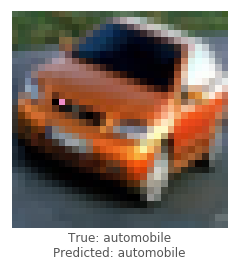

Attacking image 7227 - 89 / 100


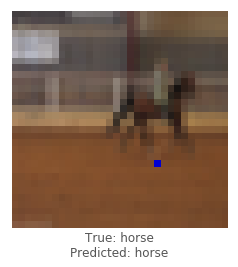

Attacking image 1839 - 90 / 100


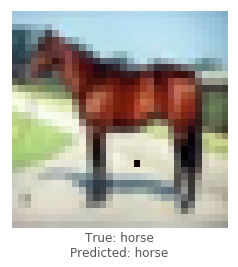

Attacking image 365 - 91 / 100


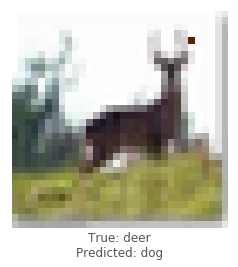

Attacking image 1767 - 92 / 100


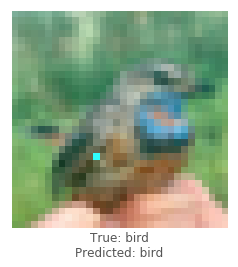

Attacking image 4351 - 93 / 100


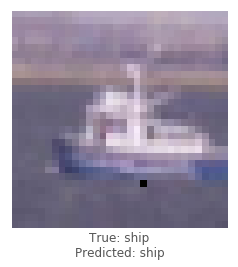

Attacking image 34 - 94 / 100


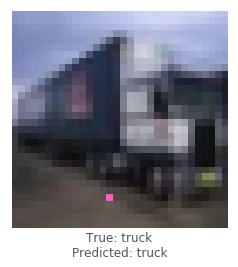

Attacking image 8378 - 95 / 100


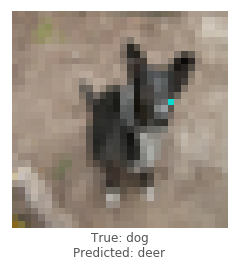

Attacking image 3990 - 96 / 100


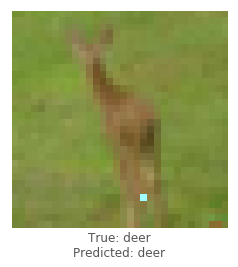

Attacking image 6299 - 97 / 100


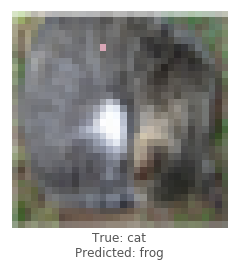

Attacking image 318 - 98 / 100


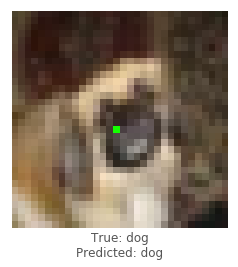

Attacking image 8475 - 99 / 100


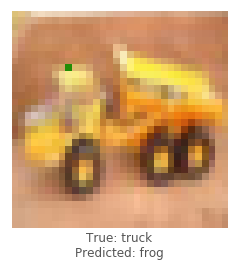

Attacking image 6208 - 100 / 100


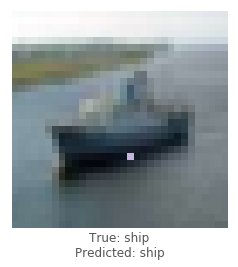

Attacking image 7924 - 1 / 100


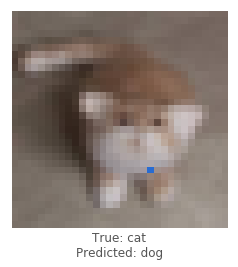

Attacking image 565 - 2 / 100


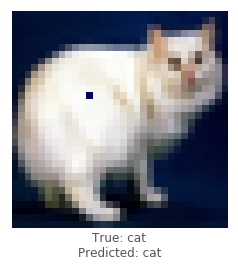

Attacking image 5551 - 3 / 100


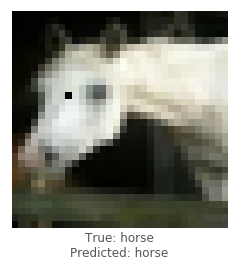

Attacking image 2234 - 4 / 100


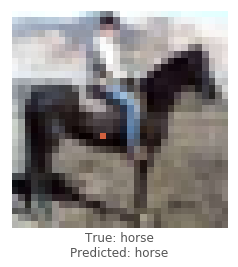

Attacking image 1057 - 5 / 100


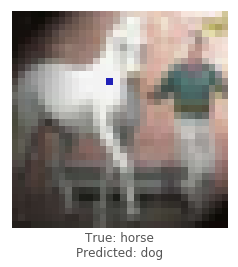

Attacking image 7603 - 6 / 100


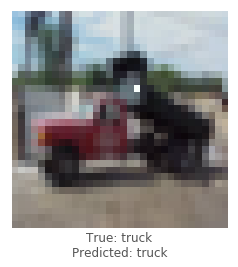

Attacking image 1441 - 7 / 100


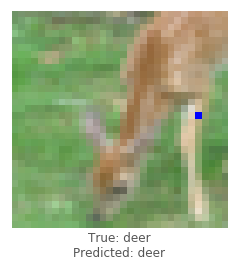

Attacking image 9871 - 8 / 100


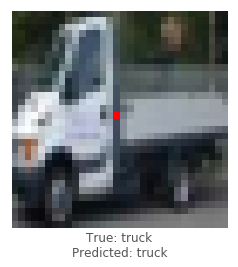

Attacking image 2662 - 9 / 100


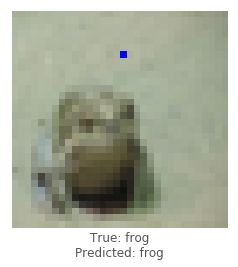

Attacking image 5060 - 10 / 100


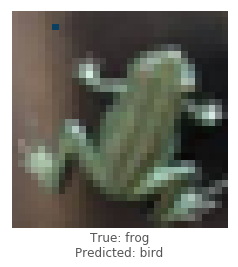

Attacking image 8408 - 11 / 100


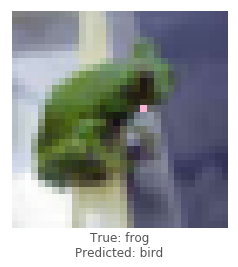

Attacking image 1179 - 12 / 100


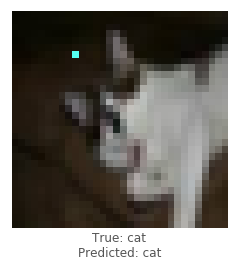

Attacking image 8851 - 13 / 100


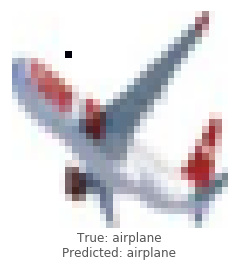

Attacking image 4852 - 14 / 100


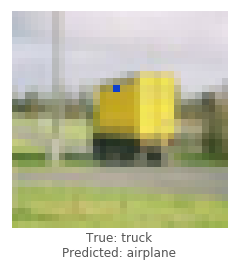

Attacking image 3523 - 15 / 100


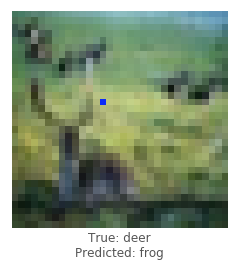

Attacking image 5502 - 16 / 100


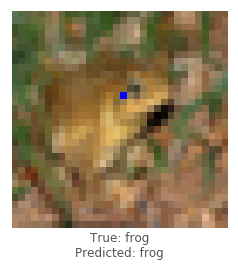

Attacking image 9026 - 17 / 100


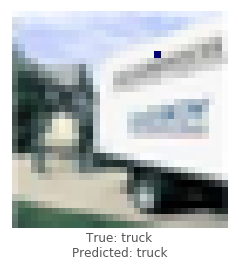

Attacking image 3431 - 18 / 100


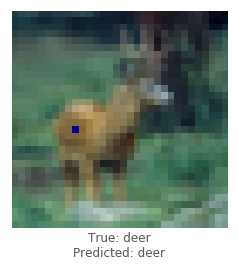

Attacking image 314 - 19 / 100


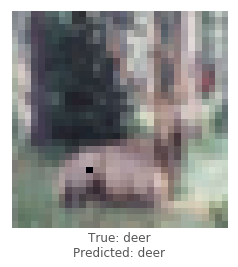

Attacking image 9032 - 20 / 100


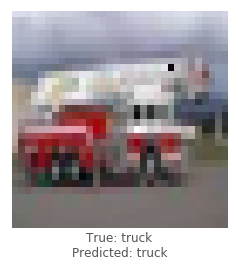

Attacking image 3395 - 21 / 100


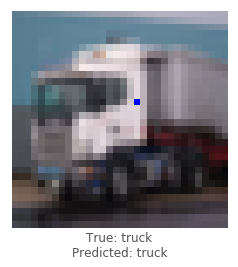

Attacking image 5723 - 22 / 100


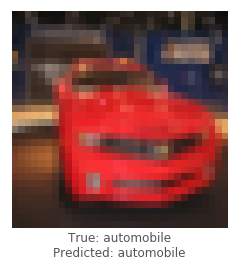

Attacking image 1827 - 23 / 100


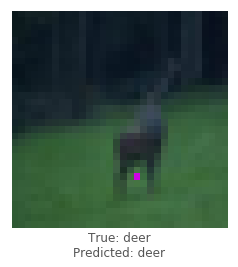

Attacking image 1253 - 24 / 100


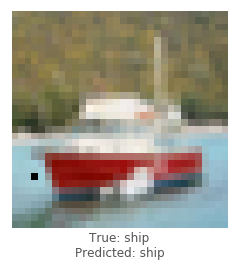

Attacking image 1361 - 25 / 100


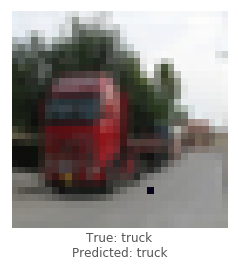

Attacking image 3916 - 26 / 100


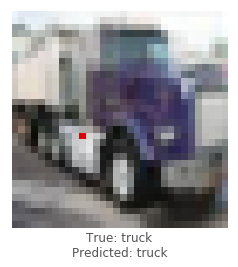

Attacking image 6258 - 27 / 100


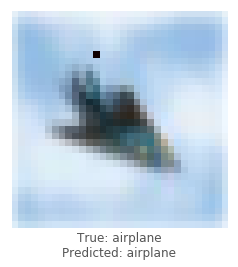

Attacking image 2685 - 28 / 100


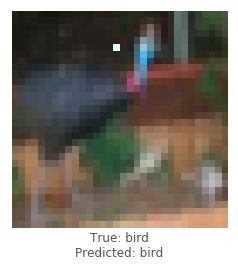

Attacking image 8554 - 29 / 100


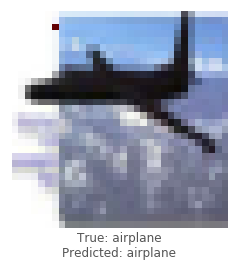

Attacking image 8005 - 30 / 100


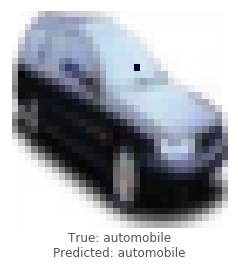

Attacking image 8493 - 31 / 100


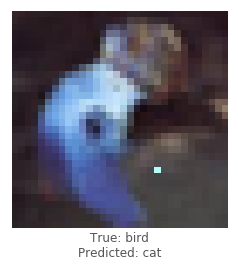

Attacking image 3743 - 32 / 100


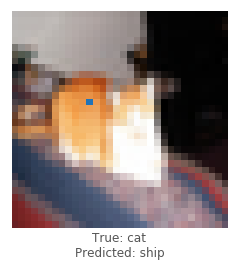

Attacking image 8073 - 33 / 100


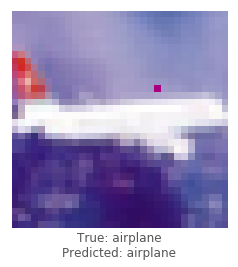

Attacking image 2867 - 34 / 100


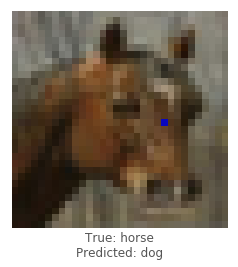

Attacking image 644 - 35 / 100


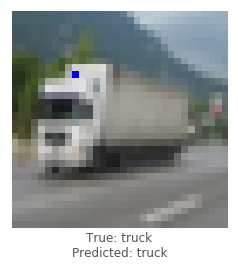

Attacking image 4961 - 36 / 100


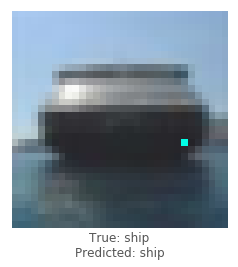

Attacking image 7106 - 37 / 100


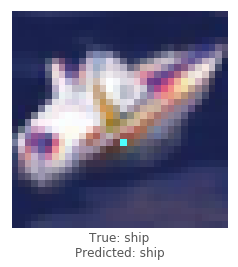

Attacking image 4522 - 38 / 100


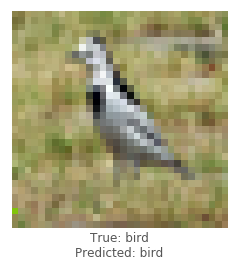

Attacking image 8566 - 39 / 100


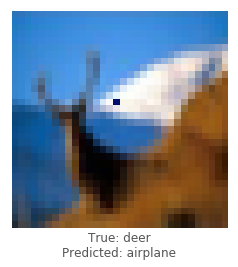

Attacking image 8116 - 40 / 100


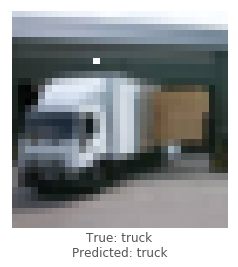

Attacking image 9565 - 41 / 100


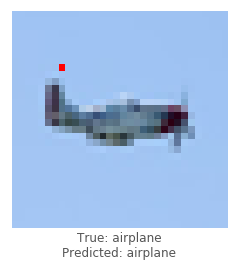

Attacking image 6725 - 42 / 100


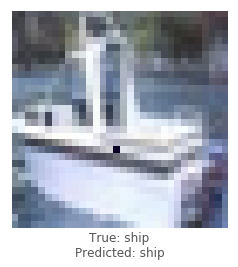

Attacking image 5401 - 43 / 100


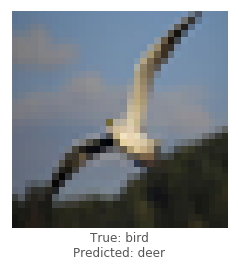

Attacking image 9325 - 44 / 100


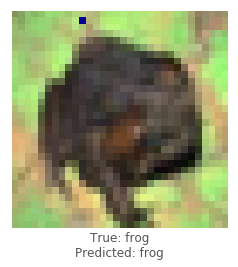

Attacking image 674 - 45 / 100


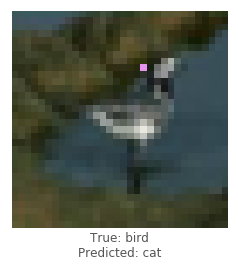

Attacking image 7505 - 46 / 100


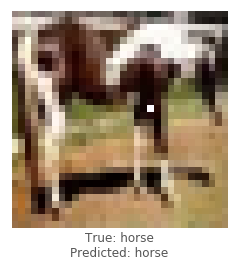

Attacking image 4551 - 47 / 100


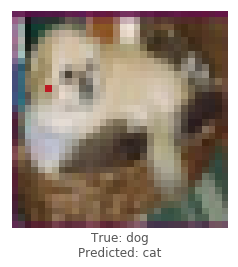

Attacking image 5259 - 48 / 100


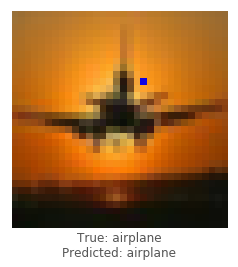

Attacking image 5049 - 49 / 100


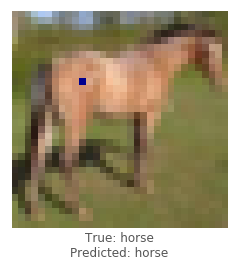

Attacking image 667 - 50 / 100


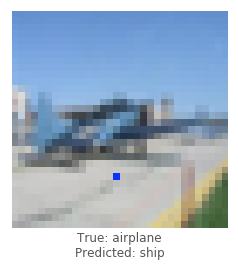

Attacking image 2970 - 51 / 100


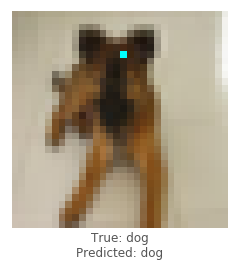

Attacking image 3095 - 52 / 100


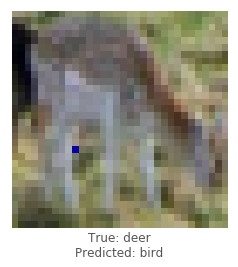

Attacking image 2697 - 53 / 100


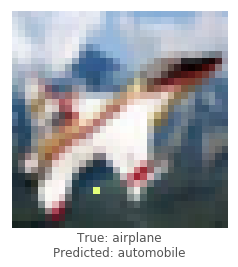

Attacking image 4951 - 54 / 100


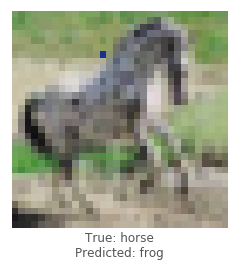

Attacking image 3822 - 55 / 100


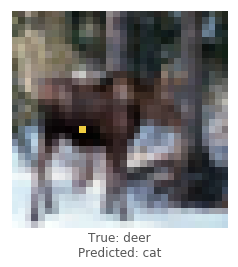

Attacking image 6041 - 56 / 100


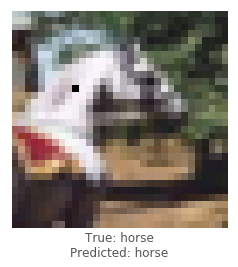

Attacking image 4536 - 57 / 100


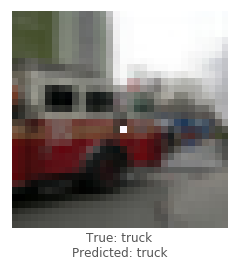

Attacking image 1091 - 58 / 100


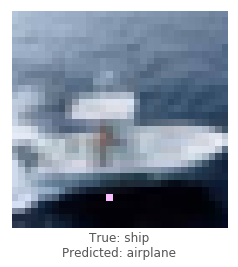

Attacking image 203 - 59 / 100


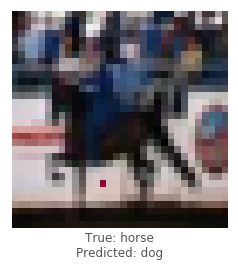

Attacking image 8277 - 60 / 100


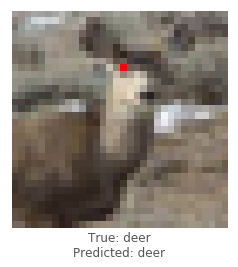

Attacking image 8412 - 61 / 100


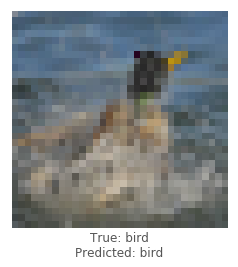

Attacking image 4330 - 62 / 100


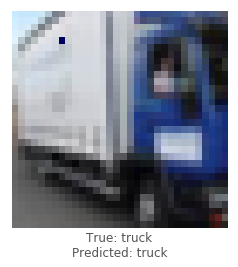

Attacking image 1179 - 63 / 100


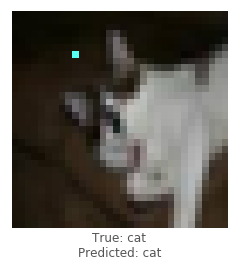

Attacking image 8665 - 64 / 100


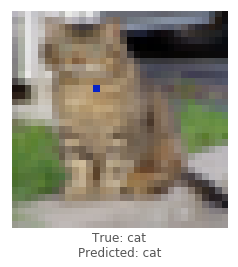

Attacking image 9316 - 65 / 100


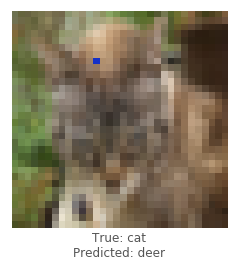

Attacking image 6096 - 66 / 100


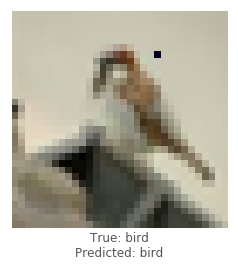

Attacking image 2883 - 67 / 100


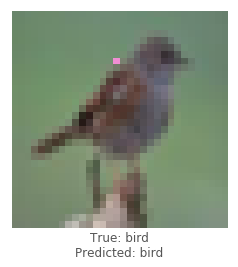

Attacking image 3437 - 68 / 100


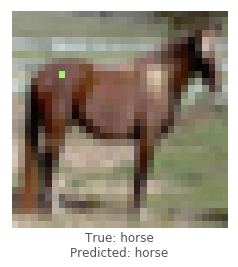

Attacking image 3040 - 69 / 100


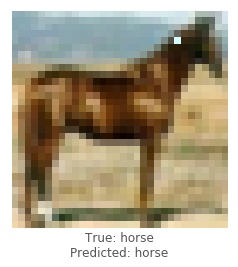

Attacking image 2716 - 70 / 100


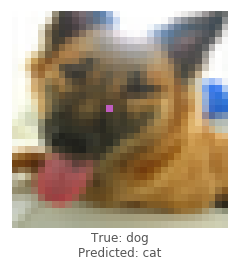

Attacking image 1029 - 71 / 100


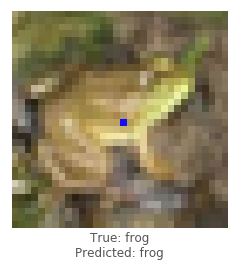

Attacking image 363 - 72 / 100


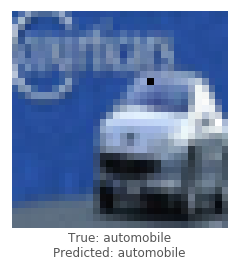

Attacking image 2053 - 73 / 100


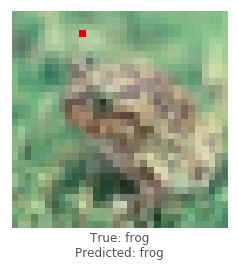

Attacking image 8359 - 74 / 100


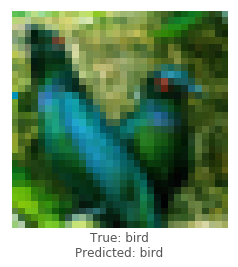

Attacking image 5168 - 75 / 100


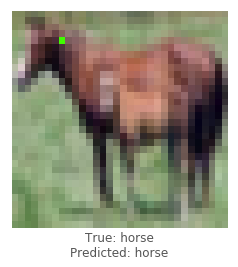

Attacking image 4341 - 76 / 100


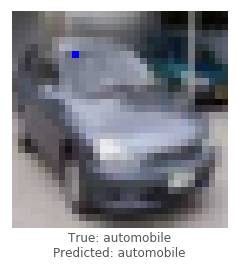

Attacking image 3565 - 77 / 100


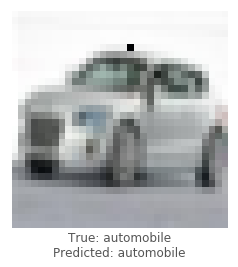

Attacking image 5711 - 78 / 100


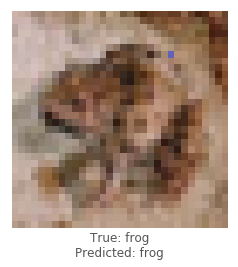

Attacking image 6879 - 79 / 100


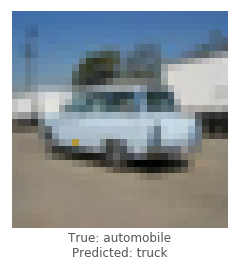

Attacking image 6926 - 80 / 100


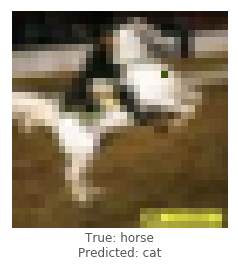

Attacking image 8348 - 81 / 100


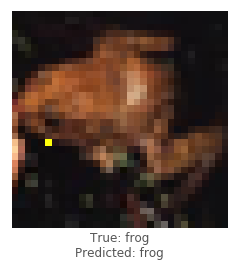

Attacking image 5904 - 82 / 100


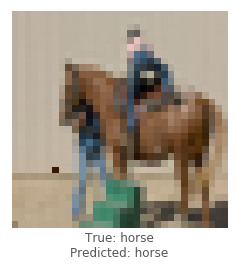

Attacking image 6728 - 83 / 100


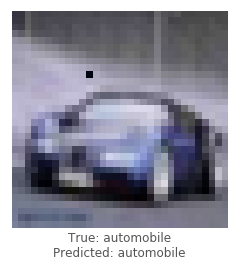

Attacking image 5347 - 84 / 100


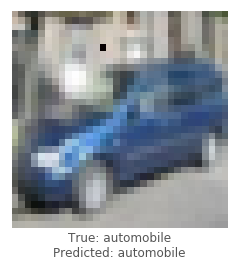

Attacking image 3010 - 85 / 100


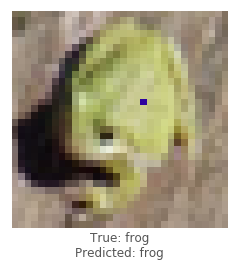

Attacking image 3423 - 86 / 100


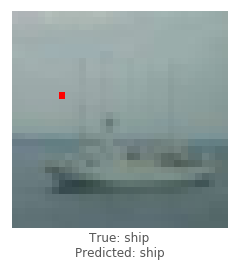

Attacking image 4345 - 87 / 100


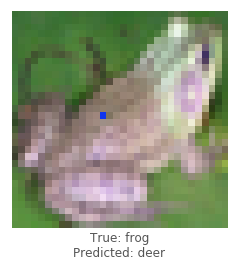

Attacking image 4396 - 88 / 100


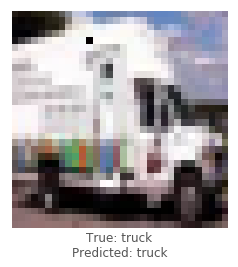

Attacking image 7944 - 89 / 100


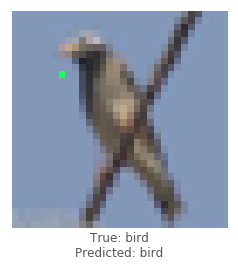

Attacking image 6526 - 90 / 100


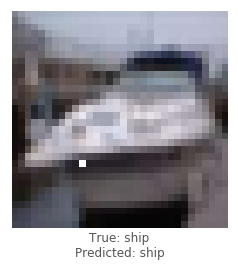

Attacking image 4216 - 91 / 100


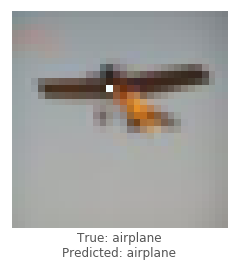

Attacking image 7602 - 92 / 100


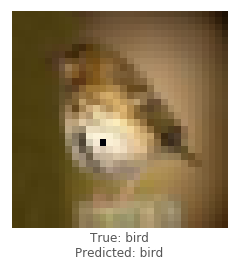

Attacking image 9458 - 93 / 100


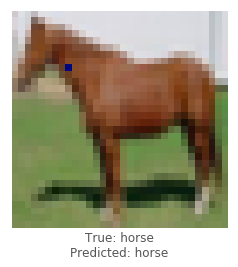

Attacking image 3720 - 94 / 100


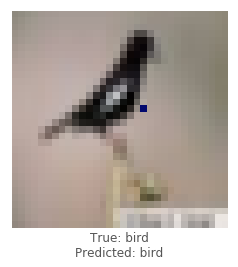

Attacking image 6647 - 95 / 100


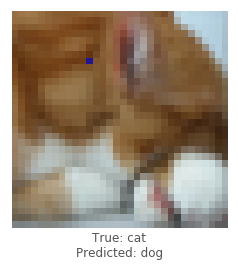

Attacking image 2652 - 96 / 100


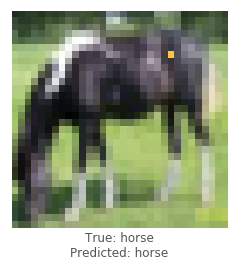

Attacking image 8442 - 97 / 100


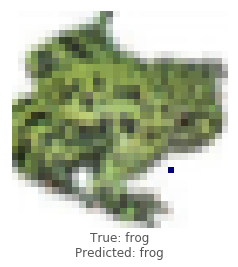

Attacking image 6278 - 98 / 100


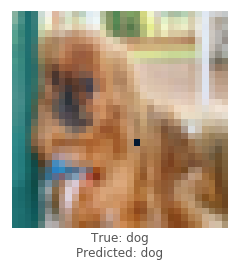

Attacking image 5019 - 99 / 100


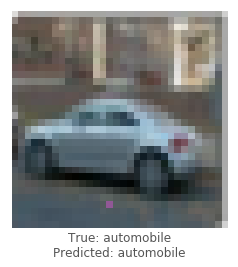

Attacking image 2699 - 100 / 100


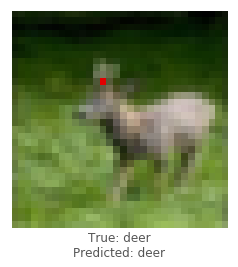

In [39]:
untargeted = attack_all(models, samples=100, pixels=[1], targeted=False)

In [ ]:
targeted = attack_all(models, samples=10, pixels=[1], targeted=True)

### Attack Statistics

In [41]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'attack_image']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [171]:
attack_stats(untargeted_results)

model  accuracy  attack_success_rate
0   lecun_net    0.7488                 0.59
1    pure_cnn    0.8877                 0.16
2  net_in_net    0.9074                 0.27
3      resnet    0.9231                 0.26

#### Targeted

In [172]:
attack_stats(targeted_results)

NameError: name 'targeted_results' is not defined

### Show some successful attacks

Plot 9 random misclassified images

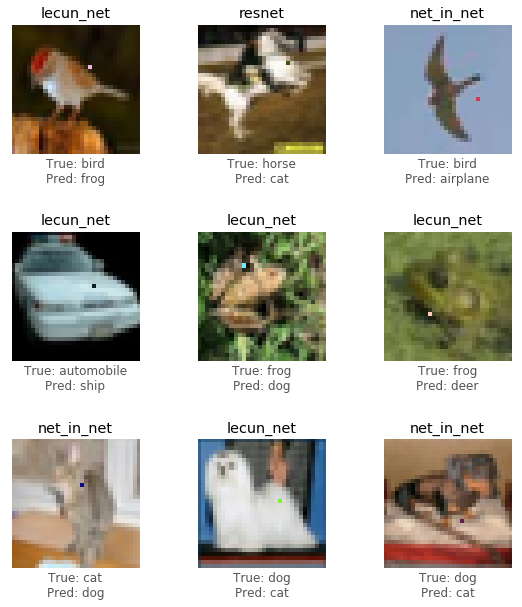

In [148]:
visualize_attack(untargeted_results, class_names)

In [ ]:
visualize_attack(targeted_results, class_names)

## Credits
 - Base code taken from https://github.com/09rohanchopra/cifar10
 - https://arxiv.org/pdf/1412.6806.pdf
 - https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
 - https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
 - http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
 - https://parneetk.github.io/blog/cnn-cifar10/
 - https://github.com/dnlcrl/deep-residual-networks-pyfunt/blob/master/docs/CIFAR-10%20Experiments.ipynb